In [1]:
#  !pip install google-colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir()

os.chdir('/content/drive/MyDrive/NUEVA EPS COD/Translado_contributivo')

%pwd

'/content/drive/MyDrive/NUEVA EPS COD/Translado_contributivo'

**Instalación de las librerías necesarias para el proceso**

In [3]:
# @title Intalación de paquetes adicionales necesarios
!pip install pyLDAvis==2.1.2
!pip install gensim
# muy costoso computacionalmente, tarda bastante, te recomiendo usar AWS
!pip install pyspellchecker
# NEUTRAL, POSIITIVA, NEGATIVA
!pip install spanish-sentiment-analysis
!pip install sentiment-analysis-spanish
!pip install keras tensorflow
# Necesaria para el proceso de traducción VERSION FREE 15000 CARACTARES
#!pip install googletrans
!pip install googletrans==3.1.0a0
# Para eliminar posibles emojis
!pip install emoji
# Para procesar texto de manera rápida con tensorflow
!pip install tweet-preprocessor

**Instalación del diccionario que contiene las palabras clasificadas según los sentimientos, esta parte es para evaluar el vocabulario empleado a los agentes**

In [4]:
# ###################EMOLEX
# Eliminamos la carpeta EmoLex en caso de que exista
!rm -rf EmoLex/
# Descargamos un .zip con el léxico
!wget -O emolex.zip https://raw.githubusercontent.com/larajuse/share/master/EmoLex.zip
# Descomprimimos el .zip
!unzip emolex.zip

--2021-03-07 23:31:35--  https://raw.githubusercontent.com/larajuse/share/master/EmoLex.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52446 (51K) [application/zip]
Saving to: ‘emolex.zip’

emolex.zip          100%[===================>]  51.22K  --.-KB/s    in 0.01s   

2021-03-07 23:31:35 (4.79 MB/s) - ‘emolex.zip’ saved [52446/52446]

Archive:  emolex.zip
   creating: EmoLex/
  inflating: EmoLex/joy.txt          
  inflating: EmoLex/positive.txt     
  inflating: EmoLex/anticipation.txt  
  inflating: EmoLex/trust.txt        
  inflating: EmoLex/fear.txt         
  inflating: EmoLex/sadness.txt      
  inflating: EmoLex/surprise.txt     
  inflating: EmoLex/anger.txt        
  inflating: EmoLex/disgust.txt      
  inflating: EmoLex/negative.txt     


In [5]:
#@title Librerías para NLP
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import re #expresiones regulares
import itertools
from collections import Counter 
import seaborn as sns
import matplotlib as mpl
plt.style.use('ggplot')
sns.set_context("talk")
import datetime
import dateutil

#Librerias de visualizacion dinámica
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud
from pprint import pprint #Manipulacion de datos

#LDA MODEL FOR OBSERVACIONES
#quitar mas profundamente stop_words
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import unicodedata
import tqdm
import spacy.cli
from spacy.lang.es.stop_words import STOP_WORDS 
#descargamos los modelos
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install preprocessor
import preprocessor as p
nltk.download('stopwords')
spacy.cli.download("es_core_news_md")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [6]:
####LIBRERIAS EMOCIONES
#@title Librerías de emociones
from collections import defaultdict

#!pip install googletrans
import googletrans
from googletrans import Translator
!pip install emoji
import emoji
import os
from sklearn.preprocessing import MinMaxScaler

#############LSTM
import sklearn 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import load_model
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing import text, sequence
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

**Las siguientes librerias son necesarias para estudiar las relaciones semánticas**

In [7]:
#@title Librerías necesarias para realizar el modelo de Word2Vec
#word2vec modelo de EMBEDDING
#word2vec
from gensim.models import word2vec
import multiprocessing
from gensim.models import Word2Vec
from collections import defaultdict 
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from pylab import rcParams
from google.colab import widgets

**Librerias necesarias para evaluar la experiencia general del cliente, no es necesario traducir el texto para este paso**

In [8]:
#@title Librerias necesarias para evaluar la experiencia general del cliente
#clasificacion de sentimientos, en español

#!pip install wordcloud
#!pip install spellchecker
#!pip install indexer


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from spellchecker import SpellChecker
spell = SpellChecker(language='es')
from classifier import *
clf = SentimentClassifier()
from pylab import rcParams
from google.colab import widgets

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [9]:
#@title Librerías para aplicar el modelo de LDA
## APLLY LDA MODEL TO OBSERVACIONES
#Gensim para modelado de temas, indexación de documentos y recuperación de similitudes con grandes corpus
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#Spacy para la lemmatization
import spacy
# Herramientas de graficado
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Habilitado de logging para gensim (opcional)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



Funciones globales para la limpieza de texto

In [10]:
def elimina_tildes(cadena):
  #Función para eliminar acentos en el texto
              s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
              return s

        
def clean_text(text):

          ''' remove text in square brackets, remove punctuation and remove words containing numbers.'''
          text=re.sub('0','O',text)
          text = re.sub('\w*\d\w*', '', text)
          text = re.sub('[‘’“”?¿#&¡!\/$%()\|/*+=-@]', '', text)
          text= re.sub('[!"#$%&\'()*+-/<=>?@[\\]^_{|}]', '', text)
          text=re.sub('[~Œƒ„‰Š‹•™›Ÿ¢£¤¦§¨©ª«¬®°²³´µ¶·¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÒÓÔÕÖ×ØÙÚÛÜÝÞß÷]','', text, flags=re.UNICODE)
          text=re.sub(':','', text, flags=re.UNICODE)
          return text

def replace(word):
  #arregla palabras como holaaa----hola, rrapido-----rapido- raaaaaaaaaaaaaaaaaapido---rapido
     if wordnet.synsets(word):
       return word 
     repl_word = re.compile(r'(\w*)(\w)\2(\w*)').sub(r'\1\2\3', word) 
     if repl_word != word:            
       return replace(repl_word)        
     else:            
       return repl_word 


def s_correction( text, patterns): 

  #Función auxiliar que corrige errores ortográficos, como rezpeto---respeto, se debe pasar una lista con estas correciones

          patterns1 = [(re.compile(regex), repl) for (regex, repl) in   patterns]      
          s = text       
          for (pattern, repl) in patterns1:        
                 (s, count) = re.subn(pattern, repl, s)    
          return s
    
def remove_stop(x, lista):
  #Función que optimiza la remoción de stop-words
  pattern = re.compile(r'\b(' + r'|'.join(lista_stop_words) + r')\b\s*')
  text = pattern.sub(' ',x)
  return text

def clean_text_p(text):
  #Quita palabras cortas 
        ''' remove text in square brackets, remove punctuation and remove words containing numbers.'''
        text =  re.sub(r'\b\w{1,3}\b', '', text) 
        return text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [11]:
FOLDER_EMOTION_ANALISIS = "/content/drive/MyDrive/NPL/emotion_analysis/"
FOLDER_DATASET_TRANSCRIPT = "/content/drive/MyDrive/NPL/"
FOLDER_STOP_WORDS = "/content/drive/MyDrive/NPL/stop_word/"
FOLDER_RAW = "/content/drive/MyDrive/NPL/"

**Lectura del Dataframe**

# Carga de Archivos

In [12]:
# #Conexion con drive.
# from google.colab import drive
# drive.mount('/content/drive')
# #4/1AY0e-g7ZUuKkyeFN-va4pfLDSPJp0QAACG95cHvt4W7hPy4X6ZckrfsYVhM # mmi codigo perosnal

In [13]:
import sqlite3
import os
import pandas as pd
import re

In [14]:
lista = os.listdir()
lista

['jose_Transalados_contributivo_Agosto.db',
 'jose_Transalados_contributivo_Septiembre.db',
 'jose_Transalados_contributivo_Octubre.db',
 'my_model_emotion_trasladoscon.h5',
 'emolex.zip',
 'GENERAL_.html',
 'personal_patrones.png',
 'USUARIO  EPS (N-GRAMAS)_.html',
 'NUEVA EPS_.html',
 'vis_NUEVA EPS.html',
 'personal_topics_results.png',
 'USUARIO TRASLADO CONTRIBUTIVO_.html',
 'basica_calidad_personal_certificado.png',
 'temperatura_calidad_personal_certificado.png',
 'cardiaca_calidad_personal_certificado.png',
 'cotizante_calidad_personal_certificado.png',
 'medicamento_calidad_personal_certificado.png',
 'Experiencia emitida_palabras_agente_.html',
 'Distribución Emociones_emotion.html',
 'personal_polar_usuario_.html',
 'Experiencia general del cliente_polaridad.html',
 'Traslados_contributivo.ipynb',
 'jose_Translado_Contributivo_Diciembre.db',
 'jose_Translado_Contributivo_Enero.db',
 'jose_Translado_Contributivo_Noviembre.db',
 'EmoLex']

In [15]:
#FIltro de archivos que sean solo db
lista = pd.Series(lista)
lista = lista[lista.str.contains('.db')]
lista

0         jose_Transalados_contributivo_Agosto.db
1     jose_Transalados_contributivo_Septiembre.db
2        jose_Transalados_contributivo_Octubre.db
22       jose_Translado_Contributivo_Diciembre.db
23           jose_Translado_Contributivo_Enero.db
24       jose_Translado_Contributivo_Noviembre.db
dtype: object

In [16]:
for i in lista:
  conn = sqlite3.connect(i)
  def tables_in_sqlite_db(conn):
      cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
      tables = [
          v[0] for v in cursor.fetchall()
          if v[0] != "sqlite_sequence"
      ]
      cursor.close()
      return tables
  name =tables_in_sqlite_db(conn)
  print(i,name)

jose_Transalados_contributivo_Agosto.db ['speech_to_text']
jose_Transalados_contributivo_Septiembre.db ['speech_to_text']
jose_Transalados_contributivo_Octubre.db ['speech_to_text']
jose_Translado_Contributivo_Diciembre.db ['speech_to_text']
jose_Translado_Contributivo_Enero.db ['speech_to_text']
jose_Translado_Contributivo_Noviembre.db ['speech_to_text']


In [17]:
dfs = []
for i in lista:
  name =i
  conn = sqlite3.connect(name)
  nameTable =tables_in_sqlite_db(conn)
  df = pd.read_sql("select * from "+nameTable[0], con=conn)
  if re.search('agosto', name, flags=re.IGNORECASE):
    df['Mes']='Agosto'

  elif re.search('septiembre', name, flags=re.IGNORECASE):
    df['Mes']='Septiembre'

  elif re.search('octubre', name, flags=re.IGNORECASE):
    df['Mes']='Octubre'

  elif re.search('noviembre', name, flags=re.IGNORECASE):
    df['Mes']='Noviembre'

  elif re.search('diciembre', name, flags=re.IGNORECASE):
    df['Mes']='Diciembre'
  
  elif re.search('enero', name, flags=re.IGNORECASE):
    df['Mes']='Enero'
  else:
    df['Mes']='Mal_valor'
  dfs.append(df)

In [18]:
for i in dfs:
  if 'client'in i.columns:
    i['transcripcion']=i['client']

In [19]:
for i,j in zip(dfs,lista):
  print(i.shape,j)# quiero los idex para poner al lado los nombres
df_all = pd.concat(dfs).reset_index(drop = True)

(72, 7) jose_Transalados_contributivo_Agosto.db
(81, 7) jose_Transalados_contributivo_Septiembre.db
(79, 7) jose_Transalados_contributivo_Octubre.db
(72, 7) jose_Translado_Contributivo_Diciembre.db
(69, 7) jose_Translado_Contributivo_Enero.db
(80, 7) jose_Translado_Contributivo_Noviembre.db


In [20]:
df_all['Mes'].value_counts()

Septiembre    81
Noviembre     80
Octubre       79
Agosto        72
Diciembre     72
Enero         69
Name: Mes, dtype: int64

In [21]:
df_all.tail(3)

,name_file,transcripcion,speech_ratio,confidance,owner,raw,Mes,agent,client
450,l0040424062_DATE-20201111134309_135901_NIT-X_C...,buenos días carol jordan sería bajarte de lla...,0.711,0.720833,NaN,NaN,Noviembre,venía mañana presionada la carol parra quien ...,buenos días carol jordan sería bajarte de lla...
451,l0040475619_DATE-20201120100614_102956_NIT-X_C...,buendía milena cómo estás habla meredith y to...,0.806,0.732500,NaN,NaN,Noviembre,bienvenido a la luna trae buenas buenos días ...,buendía milena cómo estás habla meredith y to...
452,l0040478196_DATE-20201120151210_152835_NIT-X_C...,con anna buenas tardes hablas con marle niños...,0.807,0.561429,NaN,NaN,Noviembre,muy buenas tardes bienvenido a la línea de at...,con anna buenas tardes hablas con marle niños...


In [22]:
df_user = df_all.copy()# com ose cuenta con canal mono con agente y usuario se carga todo en user para depues lipiar al agente.
df_user.index.duplicated().sum()

0

Division del daframe Agente y usuario

In [23]:
# df_agent=df_user[df_user.owner=='agente']
# df_user=df_user[df_user.owner=='usuario']
# df_user= df_user.reset_index(drop=True)
# print('dimensionalidad agente:', df_agent.shape)
# print('dimensionalidad usuario:', df_user.shape)

Creacion de variables para detectar atipicos


In [24]:
#df_agent['len_trans']=df_agent['transcripcion'].apply(lambda x: len(x))
df_user['len_trans']=df_user['transcripcion'].apply(lambda x: len(x))

df_user['media'] = df_user['len_trans'].mean(axis=0)
df_user['desv'] = df_user['len_trans'].std(axis=0)
df_user['lim_atip_max'] = df_user['media'] + (3*df_user['desv'])
df_user['atipico'] = df_user['len_trans'] >= df_user['lim_atip_max']

df_agent_afi = df_user
df_user = df_user[df_user['atipico']==False]
len(df_user)

447

Funcion global para la frecuencia de las palabras y polaridad de sentimientos

In [25]:
def plot_10_most_common_words(count_data, count_vectorizer):
   #Grafico de frecuencias
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:15]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    fig = px.bar( x=words, y=counts, color_discrete_sequence=["#25427B","#33BBFF","#EBECED"], title='TÉRMINOS MÁS COMUNES EN:'+' '+segmento,  labels=dict(x="Palabra Clave", y="Frecuencia", color="Place")) #COLORES DE ECOPETROL, PUEDES VARIAR LOS COLORES
    fig.write_html(segmento+"_.html")
    fig.show()
    return words,counts

#Puntuadora de sentimientos
def polaridad(x): return np.nan if str(x) == '' else clf.predict(x)

#Ajustador de vocabulario
def adjustment_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def get_sentiment(model,text):
    text = clean_text(text)
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = sequence.pad_sequences(twt, maxlen=max_len, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result


def plot_result(df, segment):
    #colors=['#D50000','#000000','#008EF8','#F5B27B','#EDECEC','#D84A09','#019BBD','#FFD000','#7800A0','#098F45','#807C7C','#85DDE9','#F55E10']
    #fig = go.Figure(data=[go.Pie(labels=df.sentiment,values=df.percentage, hole=.3,textinfo='percent',hoverinfo='percent+label',marker=dict(colors=colors, line=dict(color='#000000', width=2)))])
    #fig.show()
    colors={'amor':'rgb(213,0,0)','vacio':'rgb(0,0,0)',
                    'incertidumbre':'rgb(0,142,248)','entusiasmo':'rgb(245,178,123)',
                    'neutral':'rgb(237,236,236)','preocupación':'rgb(216,74,9)',
                    'sorpresa':'rgb(1,155,189)','diversión':'rgb(255,208,0)',
                    'odio':'rgb(120,0,160)','felicidad':'rgb(9,143,69)',
                    'desinterés':'rgb(128,124,124)','alivio':'rgb(133,221,233)',
                    'enojo':'rgb(245,94,16)',
                    'disfrute': 'rgb(141,235,59)',
                    'miedo': 'rgb(235,59,217)'
            }
    col_2={}
    for i in df.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df,values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3,title=segment,)
    fig.show()
    fig.write_html(segment+"_emotion.html")

**PARA DETECTAR LAS EMOCIONES SIEMPRE SE DEBE CORRER LAS SIGUIENTES LINEAS:**

#LSTM FOR EMOTION EXTRACTION

En esta sección se explicará como se elaboró el modelo para la extracción de emociones de las conversaciones de los usuarios. Todos los dataset empleados están en inglés. El modelo puede elaborarse o modificarse si se logra encontrar un dataset con la clasificación de las emociones en español. También podemos mejorar el modelo corriendo con emmbedings entrenados, como word2vec u otros. El modelo ya se encuentra guardado y puede ser empleado en cualquier momento, sin embargo, si se quiere modificar el modelo, algún parámetros se iene que volver a correr y guardarlo en formato que tensor flow pueda reconocer después.

**Carga de los datos para el train**

In [26]:
data = pd.read_csv(FOLDER_EMOTION_ANALISIS+"text_emotion.csv")
data0=pd.read_csv(FOLDER_EMOTION_ANALISIS+"train.txt", sep=';',names=["content","sentiment"])

In [27]:
#Unión de los dataframes
data=data[['content','sentiment']]
data0=data0[['content','sentiment']]
data=pd.concat([data, data0],axis=0)
data.reset_index(inplace=True)
data[0:3]

,index,content,sentiment
0,0,@tiffanylue i know i was listenin to bad habi...,empty
1,1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,2,Funeral ceremony...gloomy friday...,sadness


In [28]:
#Corregir errores de tipografía,
misspell_data = pd.read_csv(FOLDER_EMOTION_ANALISIS+"spell.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Sample of the dict
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(20)]}

{'Steffen': 'Stephen',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'accomodate': 'accommodate',
 'acommadate': 'accommodate',
 'acord': 'accord',
 'adultry': 'adultery',
 'aggresive': 'aggressive',
 'alchohol': 'alcohol',
 'alchoholic': 'alcoholic',
 'allieve': 'alive',
 'alright': 'all_right',
 'aquantance': 'acquaintance',
 'equire': 'acquire',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

In [29]:
def misspelled_correction(val):
  #Función que corrige los errores de tipografía
    for x in val.split(): 
        if x in miss_corr.keys(): 
            val = val.replace(x, miss_corr[x]) 
    return val

In [30]:
data["clean_content"] = data.content.apply(lambda x : misspelled_correction(x))
data["clean_content"][0:4]

0    @tiffanylue i know  i was listenin to bad habi...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
Name: clean_content, dtype: object

In [31]:
#Contractions, Dataset que contiene las contracciones típicas del inglés lo cargamos para eliminar este
#tipo de escritura en el texto en inglés
contractions = pd.read_csv(FOLDER_EMOTION_ANALISIS+"datasets_697638_1220322_contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

In [32]:
def cont_to_meaning(val): 
  #Función que retira las contracciones en el texto (Inglés)
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

In [33]:
data.clean_content = data.clean_content.apply(lambda x : cont_to_meaning(x))
data['clean_content'][0:4]
#data['clean_content']=data.content.apply(lambda x : p.clean(x))

0    @tiffanylue i know  i was listenin to bad habi...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
Name: clean_content, dtype: object

In [34]:
#Puntuaction 
def punctuation(val): 
  #Función que remueve otro titpo de puntuaciones y simbolos
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
  
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, " ") 
    return val

**muy importante LIMPIEZA DE EMOJIS EN UN TEXTO**

In [35]:
# data.clean_content = data.clean_content.apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))

In [36]:
# def clean_text(val):
#     val = misspelled_correction(val)
#     val = cont_to_meaning(val)
#     val = p.clean(val)
#     val = ' '.join(punctuation(emoji.demojize(val)).split())
    
#     return val

In [37]:
# data = data[data.clean_content != ""]

In [38]:
#MODELING
sent_to_id  = {"empty":0, "sadness":1,"enthusiasm":2,"neutral":3,"worry":4,
                        "surprise":5,"love":6,"fun":7,"hate":8,"happiness":9,"boredom":10,"relief":11,"anger":12, "fear":13, "joy":14}

In [39]:
data["sentiment_id"] = data['sentiment'].map(sent_to_id)

In [40]:
#########################MODELADO VECTORIZACIÓN DE VARIABLES TEXTUALES

label_encoder = LabelEncoder()#Vectorización de las palabras
integer_encoded = label_encoder.fit_transform(data.sentiment_id)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

In [41]:
#División del dataset para entrenar y evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(data.clean_content,Y, random_state=1995, test_size=0.2, shuffle=True)

In [42]:
# Usando Keras para realizar la limpieza del texto
token = text.Tokenizer(num_words=None)
max_len = 160
Epoch = 5
token.fit_on_texts(list(X_train) + list(X_test))
X_train_pad = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)

In [43]:
w_idx = token.word_index
len(w_idx)

55086

In [44]:
# embed_dim = 160
# lstm_out = 250

# model = Sequential()
# model.add(Embedding(len(w_idx) +1 , embed_dim,input_length = X_test_pad.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(15, activation='softmax'))
# #adam rmsprop 
# model.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [45]:
#Elección del tamaño del bacth en el dataset general
batch_size = 32

In [46]:
%%time
#Entrenamiento del modelo, aproximadamente 3 horas
# model.fit(X_train_pad, y_train, epochs = Epoch, batch_size=batch_size,validation_data=(X_test_pad, y_test))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [47]:
# #Evaluación del modelo, con todos los accuracy 
# losses=pd.DataFrame(model.history.history)
# losses.plot();

In [48]:
# #Modelo entrenado, se puede utilizar directamente.
#model.save(FOLDER_EMOTION_ANALISIS+'my_model_emotion.h5')

#Limpieza de los audios

En esta sección se realiza una limpieza general de los audios, eliminar stop words generales como nombres apellidos, números, preposiociones y demás.

In [49]:
print(STOP_WORDS)
STOP_WORDS1=[]
for i in STOP_WORDS:
  a=elimina_tildes(i)
  STOP_WORDS1.append(i)

{'cuantos', 'ayer', 'sólo', 'tampoco', 'fuimos', 'día', 'les', 'segundo', 'sobre', 'solos', 'sabes', 'esto', 'ninguno', 'quizá', 'estar', 'tras', 'realizó', 'mayor', 'nuestras', 'estamos', 'momento', 'sera', 'sea', 'ni', 'habían', 'total', 'alguna', 'trabajas', 'podriamos', 'haciendo', 'habrá', 'debajo', 'otra', 'si', 'esa', 'aquí', 'hacemos', 'aquél', 'aquellas', 'mia', 'suya', 'delante', 'eramos', 'usan', 'enseguida', 'han', 'nuevo', 'cuatro', 'cómo', 'vaya', 'contigo', 'final', 'os', 'lado', 'sido', 'bueno', 'tres', 'usar', 'ocho', 'alrededor', 'informo', 'ti', 'hay', 'señaló', 'diferente', 'solamente', 'mal', 'este', 'sabemos', 'último', 'antaño', 'éste', 'yo', 'nuestra', 'vamos', 'deben', 'excepto', 'que', 'esos', 'muy', 'van', 'pudo', 'realizar', 'su', 'bajo', 'menudo', 'mí', 'dias', 'dio', 'cuanta', 'estará', 'poca', 'largo', 'haceis', 'ser', 'supuesto', 'ver', 'últimos', 'empleais', 'cuenta', 'intentas', 'aquel', 'sois', 'míos', 'poner', 'consigue', 'vez', 'eras', 'haya', 'podr

**Definicion** Stop words_globales

Nombres

In [50]:
a_name = ['aarn','aaron','abad','abadia','abadiano','abalo','abaunza','abbigail','abdias','abdubal','abdul','abdulio','abel','abelanid','abelardo','abella','abello','abigail','abimel','abogados','abonce','abondano','abraham','abrahan','abreo','absalon','ac','acalo','accion','acciones','acebedo','acebo','acened','acenet','aceneth','acero','acevedo','acevedoq','achicanoy','achinte','achipiz','achly','acosta','acuña','ada','adaine','adalberto','adalena','adalgisa','adalgiza','adalia','adaluz','adames','adan','adarbe','adarve','adda','adecco','adecio','adel','adela','adelaida','adelayda','adelcia','adelfa','adelina','adelinda','adelmo','adelsaina','ademir','adey','adiel','adiela','adila','adisson','admiautos','administracion','administraciones','administradora','adnelice','adolfo','adonis','adoracion','adrada','adrian','adrian','adriana','adriana','adriano','aduanas','afanador','agatha','agaton','agencia','agnelio','agrace','agraces','agrada','agreda','agredo','agregado','agricolas','agricolas','agron','agropecuaria','aguacia','aguado','agualimpia','aguas','aguayo','agudelo','agueda','aguelo','aguiar','aguilar','aguilera','aguillon','aguinaga','aguiño','aguirre','agustin','agustina','agusto','ahedo','ahumada','aiba','aicardo','aicedo','aida','aidaly','aide','aidee','aidy','aily','ailyn','aimer','aimy','ainosas','airlyng','aissa','aitana','aiza','aizmeth','ala','alaba','aladino','alaguna','alaia','alain','alan','alana','alarcon','alarcon','alava','alba','alban','albaran','albaro','albarracin','albear','albeir','albeiro','albert','alberta','alberto','albery','albey','albino','albornoz','alcalde','alcaldia','alcaldia','alcaraz','alcazar','alcibiades','alcides','alcira','alda','aldana','aldarriaga','aldemar','alderete','alderis','aldery','aldineber','alean','alechor','alegria','alegria','alegrias','aleiber','aleicy','aleida','alejandra','alejandrina','alejandro','alejjandro','alejnadro','aleman','alemesa','alencia','ales','alessandra','alex','alexa','alexander','alexandra','alexandre','alexei','alexi','alexis','alexy','aleyda','aleyi','alezander','alfa','alfaro','alferez','alfonso','alfredo','ali','alia','alianza','alicia','alicio','alicua','alida','alimentarias','alimentos','alina','alinton','aliria','alirio','alis','alisa','alisamar','alison','alisson','alix','aliz','aljadi','aljure','allison','allisson','alliver','alma','almanza','almario','almeida','almendra','almendres','almendrez','alnoimer','alomia','alondra','alonso','alos','alpaca','alpala','alquedan','alquive','alsate','altamar','altamirano','altura','alulema','aluminio','alva','alvarado','alvaran','alvarez','alvarez','alvaro','alvear','alvedia','alveiro','alvenis','alves','alviar','alvis','alviz','alyn','alysson','alzamora','alzate','alzle','ama','amada','amadeo','amado','amador','amaia','amalci','amalf','amalfi','amalfy','amalia','amall','amancio','amanda','amarfi','amariles','amaris','amaury','amaya','amazo','ambuila','ambuz','amelia','amelie','amer','america','americo','amezquita','amibia','amilcar','amilvia','amin','amina','aminta','amira','amor','amorocho','amortegui','amortiteca','amparo','ampudia','amu','amy','ana','ana|','anabeiba','anabeiva','anabel','anabela','anabolena','anacona','anahi','anahia','anaibe','anali','analida','analy','anatalia','anavela','anaya','anayaeli','anayibe','anayiber','anchico','ancizar','and','ander','anderson','andersson','andica','andrade','andre','andrea','andreina','andres','andres','andrew','andrey','andry','anduquia','andy','anely','anganoy','angarita','angel','angel','angela','angeles','angeli','angeli','angelica','angelica','angelik','angelina','angeline','angelino','angello','angelly','angelo','angely','angge','anggy','angi','angie','angiee','angisay','angola','angrino','angucho','angulo','angy','anibal','anidisney','anirley','anita','anjie','anllely','anlly','anna','anni','annie','annirley','anny','anonio','anrrango','ante','antero','anthonella','anthony','antia','antidio','antimo','antolinez','antonella','antoni','antonia','antonieta','antonio','antony','antuan','anturi','anuar','anyel','anyela','anyeli','anyella','anyelli','anyelo','anyely','anyi','anyuri','anzola','añasco','apache','aparicio','apellidos','apolinar','apolinaria','apolindar','aponte','aponza','apostol','apraez','aptos','aqueli','aquilina','ara','araceli','aracelly','aracely','aragon','aragon','aramburo','araminta','arana','aranda','arandia','arando','aranelly','arango','aranguren','arantxa','aranza','aranzazu','araque','arara','ararat','arasmith','araujo','arbeiro','arbelaez','arbey','arboleda','arcadio','arce','arcelia','arcelio','arcenio','arces','arcesio','arcila','arcini','arciniega','arciniegas','arcira','arcley','arcon','arcos','ardila','aredondo','areiza','arelis','arellano','arena','arenales','arenas','arevalo','argelia','argemiro','argenis','argenys','argenzola','argermiro','argidia','argote','argoti','argotte','argoty','arguello','ariadna','ariana','ariane','arias','aricapa','aricia','ariel','ariela','aris','arismendi','arismendy','arist','aristides','aristizabal','aristizabal','aristobulo','ariza','arizabalate','arizabaleta','arizala','arizmendi','ariztizabal','arlency','arleny','arles','arlesa','arlex','arley','arlony','arly','armando','armenia','armero','armida','arnedo','arnobia','arnobio','arnoby','arnoldo','arnolfo','arnolia','arnoris','arnory','arnubia','arnulfo','aroca','arocemena','arosa','arosemena','arpesod','arquimedes','arrechea','arredondo','arrerondo','arriaga','arrias','arriero','arrieta','arris','arrollo','arroyabe','arroyave','arroyo','arrubia','arrubla','arsayus','arsecio','arsenio','arsesio','arteaga','artemio','artemo','artiaga','artunduaga','arturo','arvey','ary','arzayus','arzayuz','asbeidy','ascanio','ascencio','asceneth','ascension','ascuntar','asdrubal','asencion','aseneth','aseo','asesorias','ashley','ashli','ashlly','ashly','asis','aslan','asly','asmed','asmucol','asnoraldo','asociacion','asociados','asprilla','astaiza','astañeda','astella','asteria','asterio','astolfo','astrid','astros','astudillo','atanasio','ategue','atehortua','athala','atias','atuesta','audberto','audini','audivert','audrey','audry','augusto','aulestia','aulia','aulin','aura','auraelina','aurelena','aurelia','aureliano','aurelina','aurelinas','aurelio','auristella','aurita','aurora','ausecha','ausique','austin','autocorp','autonoma','aux','auxilio','avalo','avalos','avella','avendaño','avieser','avila','avila','aviles','avirama','avril','axel','aya','ayala','ayazo','aychell','ayda','ayde','aydee','aydivy','ayerbe','ayerve','ayili','aylin','aymer','ayner','ayora','ayovi','ayuda','aza','azael','azcarate','azucena','azyade','b.','babativa','baca','bacca','badillo','bados','baena','bahamon','bahamon','bahos','baicue','bairon','balanta','balantalina','balbin','balbina','balcazar','balcazar','baldemar','baldomero','baldrich','balladalez','ballen','ballestas','ballesteros','balmes','balmory','baltan','baltazar','balvin','bambague','banderas','banessa','banguera','banguero','banol','banoy','banquet','bañol','baos','baquero','barahona','barandica','barbara','barbetti','barbosa','barcenas','barco','barlaham','barney','baron','barona','barragan','barrantes','barreiro','barreneche','barrera','barrero','barreto','barrientos','barriga','barrios','barroso','barrrera','bartola','bartolo','bartolome','basante','basilia','basilio','bastidas','basto','bastos','batero','batioja','bautista','bayardo','bayer','bayona','bayron','bazan','bazantes','bbva','beatris','beatriz','beca','becca','beccy','becerra','becoche','bedolla','bedon','bedoya','beiba','beimer','bejarano','beky','bela','belalcazar','belarmina','belavenko','belen','belinda','belisa','belisario','belizabet','bella','bellaizan','bellalid','bello','belly','belquiz','beltran','beltran','benachi','benalcazar','benardo','benavides','benavidez','benedicto','benemerito','benhur','benicia','benicio','benigno','benilda','benilde','benites','benitez','benito','benjamin','benjamin','benjumea','benvides','benzon','berardo','berenice','berfalia','bermeo','bermudez','bermudez','bermuidez','bernabe','bernal','bernales','bernarda','bernardo','bernate','bernelio','berney','beron','beronica','berrio','berta','bertha','berthalia','bertil','bertilda','bertilde','bertulfo','besrnal','bessy','betancour','betancourt','betancourth','betancur','betancurluis','betancurt','betancurth','betes','bethy','betsabe','betsabeth','betsy','betty','betulia','beyanil','beylin','bibian','bibiana','biggitti','billy','biojo','birmany','biscue','biscunda','bislealdo','bismar','biteli','biuza','biviam','bivian','biviana','blackburn','bladimir','blainer','blanca','blanco','blandon','blandon','bleik','bleisi','blexon','bobadilla','bocanegra','bogota','bohorquez','bojaca','bojorge','bolaños','bolañoz','bolena','bolivar','bolivia','bolney','bomberos','bone','bonifacia','bonilla','booder','borda','boris','borja','bornachera','borrais','borras','borrero','botache','botello','botero','botina','bouzas','bpo','brady','brahant','brahiam','brahian','brahyam','bram','bran','brand','brandon','brasilia','bravo','brayam','brayan','braynny','bredy','breiner','brenda','brenyer','breychell','breydy','breyner','brian','briceida','bricella','briceño','briches','bridge','bridgee','brigette','briggitte','brigid','brigida','brigitte','brilli','brillit','brillith','brilly','brillyth','brindarly','briñez','brito','britsy','brittany','britto','briyid','briyith','briyitt','broquis','bruce','brunilda','bryan','bryllitte','btancourth','bubu','bucanero','bucheli','buchelli','buelvas','buenaventura','buendia','bueno','buesaquillo','buga','buila','builes','buitrago','buitron','bula','burbano','burgos','burgues','buritica','buritica','busscar','bustamante','bustillos','bustos','byron','c','cabal','caballero','cabanillas','cabanzo','cabezas','cabral','cabrales','cabrera','cacais','caceres','caceres','cadavid','cadena','caez','cafe','cagua','caguasango','cagueñas','caicedo','caipe','cairasco','caisa','caja','cajares','cajas','cajiado','cajiao','cajica','cajigas','calambas','calapsu','caldas','calderon','calderon','caldon','caleb','caleño','calero','calibio','calima','caliredes','calle','callejas','calles','calonge','calonje','caludia','calvache','calvaran','calvo','calzada','camacho','camargo','camayo','cambindo','camelo','camila','camilo','camla','campaña','campas','campaz','campeon','campiño','campo','campoelias','campos','campuzano','canabal','canache','canal','canaz','canchala','canchon','cancimance','cancimanci','candamil','candel','candela','candelo','candida','cando','canencio','canga','canizales','canizalez','cano','cansimanse','cantero','cantillo','cantor','canvindo','caña','cañar','cañarte','cañas','cañaveral','cañizalez','cañola','cañon','capera','capote','capurro','carabali','carabalica','caraballo','caracas','carbonell','carbonero','cardenas','cardenas','cardeño','cardiel','cardona','cardoso','cardoza','cardozo','cardula','caren','cargues','caridb','carillo','carime','carina','carla','carlina','carlo','carlomar','carlos','carlosama','carlota','carmelina','carmelita','carmelo','carmen','carmensa','carmenza','carmeza','carminia','carmiña','carmona','carnes','caro','carol','carola','carolan','carolay','carolina','caroll','carranza','carrascal','carrasquilla','carreño','carrera','carrero','carretero','carriillo','carrillo','cartagena','carton','carvajal','carvjal','casa','casadiego','casallan','casallas','casamachin','casanova','casañas','casaran','casas','casierra','casilimas','caso','casseta','cassetta','casso','castaneda','castano','castañeda','castaño','casteblanco','castelblanco','castellano','castellanos','casteñeda','castiblanco','castilla','castillo','castilo','castiño','castrillo','castrillon','castro','castsñeda','catacoli','catacoly','catalina','catalino','catamuscay','cataño','caterin','cathalina','catherin','catherine','cathy','catuche','cauca','caucayo','caviche','caviedes','caycedo','cc','cdem&cdeb','ceballos','cebastian','cecilia','cecilio','cedano','cedeño','cediel','ceferino','ceforo','celada','celades','celen','celene','celeni','celeny','celeste','celestino','celi','celia','celimo','celina','celis','celiz','celmira','celorio','celsa','celso','celvia','cely','cenaida','cenaira','cenayda','cened','ceneida','cenelia','cenelli','cenelly','cenen','ceneyda','cenide','cenider','cenobia','cenon','centeno','centro','cepeda','cerezo','ceron','ceron','cerpa','cerquera','cerrato','cersain','certuche','cervantes','cervera','cesar','cespedes','cess','cexprom','cha','chachanoy','chachinoy','chacon','chacua','chacue','chaguendo','chagueza','chaia','chaire','chala','chalacan','chalarca','chalare','chalarga','chambo','chambueta','chamizas','chamizo','chamorro','champutiz','chanchi','chantre','chañag','chapal','chaparro','chapid','chapurri','chara','charelin','charfuelan','chariana','charlotte','charon','charria','charrupi','charry','chasqui','chate','chaura','chausa','chaux','chavarria','chavarriaga','chavarro','chaverra','chaves','chavez','chayrla','chazatar','chazy','chec','checa','chelsea','chen','chenche','chepe','cheverry','chia','chiappe','chica','chicaiza','chicangana','chicue','chila','chilama','chilehuit','chilito','chilo','chima','chimachana','chimunja','chincha','chinchila','chinchilla','chinguad','chipichape','chiquito','chirley','chirpofer','chistian','chitan','chitiva','chito','choco','choconta','chocue','choi','cholo','chore','christiam','christian','christophe','christopher','christother','chrystian','chucrala','chud','chujfi','churi','cia','cidre','cielo','cifuentes','cilene','cileny','cilia','cindrid','cindy','cinia','cinthia','cinthya','cintya','cirley','ciro','cisley','cisneros','cisto','civiles','clair','claire','clara','clarena','clarencio','claret','claribel','claritza','clarivel','clariza','claros','claudia','claudina','claudineth','claudio','claver','clavijo','clayde','cleiser','cleiver','clelia','clemencia','clemente','clementina','cleofe','cleofelina','cleotilde','climaco','clinica','clinica','cliniserra','co','cobo','cobos','cock','cocoma','cocuñame','cocuy','codognotto','cogollo','cohecha','colina','coll','collantes','collazos','collo','colmenares','colo','colombia','colombiana','colombo','colonia','colorado','colpensiones','colviseg','combariza','comercio','cometa','comfamiliar','compañia','compuser','con','concai','concejo','concepcion','concepcion','concha','conda','conde','coneo','confecciones','congo','conindex','conny','conrado','consolacion','constain','constantino','constanza','construcciones','constructora','consuelo','consuleo','consultores','conto','contratando','contreras','cook','coolaborar','coomulsap','coopetativa','copete','coqueco','coques','coquis','coral','corbeta','corcino','cordero','cordoba','cordoba','cordobes','cordovez','corina','corleone','cornejo','cornelia','cornelio','cornelito','corodoba','coromoto','corona','coronado','coronel','corporacion','corral','corrales','correa','correal','correales','corredor','cortazar','cortes','cortez','cortinas','corzo','cosecha','cosme','cossio','costa','cotazo','cote','cotrina','covaleda','coy','cresencia','crespo','crhistian','criollo','crisdayan','crisostomo','crispin','cristal','cristancho','cristhiam','cristhian','cristhofer','cristi','cristiam','cristian','cristina','cristo','cristobal','cristofer','cristopher','cros','cruz','cruzana','crystal','crystian','cuaccialpu','cuacialpu','cuadrado','cuadros','cuaero','cuaical','cuaican','cuaicuan','cuaran','cuartas','cuasapud','cuasmayan','cuaspa','cuaspud','cuastumal','cuatin','cuaycan','cubides','cubillos','cucaita','cucalon','cuchillo','cuchimba','cuci','cucuma','cucuñame','cuellar','cuenca','cuenu','cuero','cueros','cuerpo','cuervo','cuesta','cuestas','cuetia','cueto','cueva','cuevas','cujar','cuji','cultid','cumbal','cumbe','cunda','cundumi','cupajita','cupitra','cusi','cuspian','cuspoca','custodia','custodio','cuta','cutiva','cynthia','da','dabeiba','dabeyba','dacareth','dadi','dagoberto','dagua','dahian','dahiana','dahiann','daian','daiana','daich','daifeny','daihana','dailin','dainer','daira','dairo','dairon','dais','daissy','daisy','daiyi','daizury','daladier','dalfeni','dalia','daliana','dalila','dalilly','daliri','dallana','dallys','damari','damaris','damelines','damian','damiro','damizuri','dana','dandiney','daneida','danelia','danelly','daneris','danery','daneyi','dani','dania','danicela','daniel','daniela','daniella','danilo','danilsa','danir','danis','danissa','danitza','danllely','danna','danniela','danny','danober','danora','danover','dante','dany','danyerlin','danyi','dar','daraviña','darbey','darcy','dari','daria','dariana','dario','dario','daris','darley','darli','darlid','darlin','darlina','darling','darlinton','darly','darlyn','darnelly','darwin','dary','daryery','dasly','dasy','datasae','dativa','dauqui','davalos','david','daviddavid','davila','davinson','davismach','day','dayan','dayana','dayanery','dayanna','dayhana','dayhann','dayra','dayron','daysuri','daysury','dayzury','daz','daza','dazza','deantonio','deaza','debie','debora','deborah','decio','deiba','deiber','deibi','deiby','deibys','deicy','deifa','deifan','deifeny','deimi','deiny','deiro','deisi','deison','deisy','deiva','deivi','deivid','deivis','deivy','del','dela','delayda','delbasto','delcida','delfa','delfamira','delfina','delgadillo','delgado','delgiza','delia','delina','delio','delkin','delliponti','delly','delma','delmy','delsy','delver','dely','deni','denice','denis','denise','denisse','dennis','denny','dennys','densy','denudetid','deny','denys','denyse','denzel','deossa','departamental','derazo','derek','derian','derli','derlin','derling','derlis','derlly','derly','dery','desideria','deverson','devia','devian','dey','deyaneri','deyanira','deybi','deyby','deyci','deyi','deylan','deymer','deysi','deysy','dharren','dhayana','diago','dian','diana','dianely','dianeth','dianey','dianid','diannet','dianny','diany','dias','diaz','diaz','diby','dickson','dictto','dicue','didier','didimo','diego','diela','diesel','dievely','diez','digitex','digna','dignery','dignier','dignora','dik','dila','dilan','dileny','dilfa','dilia','dillan','dilma','dilson','dilvia','dimar','dimarchy','dimas','dimate','dina','dinas','dinelli','diney','dinori','diocele','diogenes','diogne','diomedes','diomelina','diomira','dione','dioney','dionisia','dionisio','dionne','diony','dios','diosa','dioselina','diossa','diozahara','dique','direccion','directv','diriam','dirsa','disnery','disney','disneyda','dissan','dissu','distribuidora','distrital','diuza','diva','diver','divia','divian','divier','diyi','dizu','docier','dogman','dolcey','doli','dolly','dolmi','dolores','doly','domico','domiguez','dominga','domingo','dominguez','dominguez','dominic','donaciano','donatello','donatila','doney','donna','donneys','donny','donoso','dora','doracela','dorado','doralba','doralia','doralice','doralis','dorance','dorani','dorey','doreysi','doria','dorian','doriela','dorila','doris','dorlam','dorley','dorman','dorronsoro','dory','doryhan','dorys','dositeo','dosman','douglas','drews','driana','droguerias','drombo','duarte','dubal','duban','dubelly','duber','duberley','dubernal','duberney','dubian','dubys','dudli','dueñas','dufay','dulce','dulcey','dulfady','dulfary','dulfay','dulnelly','duque','duran','durango','durfay','durfey','durlandy','durley','dussan','duval','duvan','duver','duverney','dwight','dydier','dylan','dyro','dyssetth','dyvi','e','eastman','ebelia','eberney','ebet','eblin','ecco','ecdiver','echabarria','echavarria','echavrria','echegoyen','echeverri','echeverry','echevery','eda','eddie','eddier','eddna','eddy','edelmar','edelmira','edelvin','eder','ederson','edgar','edgardo','edi','ediber','edic','edid','edie','edier','edificaciones','edil','edilbe','edilberto','edilia','edilma','edilmer','edilsa','edilso','edilson','edima','edinarco','edinson','edinsonn','edinsson','edison','edisory','edit','edith','editha','editjh','edixon','edna','ednna','edoin','edson','edsson','edu','eduar','eduard','eduardo','educativa','eduerd','eduin','edulfa','edulfaris','edusmildo','edwar','edward','edwardo','edwars','edwarth','edwin','edy','efectivas','eficacia.','efigenia','efigenio','efrain','efrain','efred','efredy','efren','ega','egberto','egidio','egile','egna','egricelda','ehernan','ehivar','eida','eiden','eider','eiderman','eidi','eilin','eilyn','eiman','eimy','einar','eine','einer','eisenhooer','eiser','eivar','eiver','eiverth','el','eladio','elan','elba','elbar','elber','elbia','elcie','elcira','elcy','elda','elder','elean','eleana','eleany','eleazar','electricos','electrogenos','eledxader','elejalde','elena','elenith','eleonardo','eleonora','eleuterio','eli','elia','elian','eliana','elias','elibardo','eliberto','eliced','eliceo','elicer','elida','elider','elidier','eliecer','elina','elio','eliobel','elisa','elisabet','elisabeth','eliseo','eliud','eliver','eliza','elizabet','elizabeth','eljure','elkin','ella','elmar','elmer','elodia','eloina','eloisa','eloise','eloy','elpidia','elquin','elsa','elsi','elsidie','elsin','elsis','elson','elsy','eltidio','elva','elver','elvia','elvin','elvio','elvira','elvis','ely','elza','ema','emaida','emanuel','emaris','ember','emberto','embus','emelda','emely','emerita','emerson','emid','emidio','emigdio','emilce','emilda','emili','emilia','emiliana','emiliano','emilio','emilli','emilse','emilsen','emilssen','emily','emir','emira','emiro','emlia','emma','emmanuel','emmily','emperatriz','emplear','empresa','en','enais','enaliced','encarnacion','enciso','encizo','ened','enedis','eneida','enelia','eneriet','enerieth','eneyda','engracia','enid','enides','enidia','enidt','enilda','enio','enit','enith','enna','enny','enoc','enoe','enoris','enrioue','enrique','enriqueta','enriquez','enriquez','enrquez','enrrique','ensueño','enuar','enyell','epaminondas','epm','erasmo','eraso','erazmo','erazo','ercelly','ercilia','ercy','erdilia','eric','erica','erick','erik','erika','erlendy','ermeliza','ermila','erminda','erminia','erminso','erminsul','ermira','erned','ernedys','ernestina','ernesto','erney','ernilso','ervin','ery','esau','escalante','escallon','escamilla','escandon','escarpetta','escarraga','escarragas','escarria','escilda','esclava','escobar','escobedo','escolastica','escovar','escudero','escuela','esdrube','ese','esguerra','esilia','esimirey','esleida','eslendi','eslin','esly','esme','esmeralda','esmerlin','esmilda','esmira','esnayder','esneda','esnedy','esneider','esnelda','esnelia','esnery','esneth','esney','esneyder','esnna','españa','esparza','especialista','espejo','espeña','esperanza','espin','espinal','espinel','espinosa','espinoza','espitia','esquivel','essica','est','estacio','estafany','estanislao','esteba','estebali','esteban','estefam','estefani','estefania','estefanny','estefany','esteffany','estefhany','estefi','estela','estelia','estella','estephania','ester','esterling','estevan','esteven','esthefania','esther','estiben','estiven','estrada','estrella','estrellita','estrid','estupiñan','etayo','etelberto','etelvina','ethan','etm','etna','etsahin','eucaris','euclides','eudalia','eudocia','eufemia','eufemiano','eufracio','eufrasino','eugenia','eugenio','eugenioa','eugradis','eulalia','euli','eulises','eulofia','eulogio','eumir','eunice','eunise','euripides','euscategui','euse','eusebia','eusebio','eusse','eustacia','eustorgio','euvid','eva','evadista','evan','evangelina','evangelista','evarbo','evelia','evelier','evelin','evelina','evelio','evelly','evelsi','evelyn','evencio','evening','ever','everney','evert','eveyiseth','evolet','exdubar','exel','exela','expain','exposito','eybar','eyber','eyder','eydi','eydryan','eyiseth','eyleen','eylin','eylyn','eyzlen','ezequiel','ezray','fabara','faber','fabert','fabian','fabian','fabiano','fabio','fabioa','fabiola','fabricio','facundo','faency','fager','fahissury','faissury','faisully','faisuri','faisury','faizury','fajardo','falla','falon','fals','falya','fandino','fandiño','fanery','fanni','fannor','fanny','fanor','fanory','farfan','farid','faride','farley','farnery','farnesio','farney','fary','fatima','faustina','faustino','fausto','faver','favian','favid','favio','fayneri','faysiury','faysuli','fayzuly','fda','feder','federico','federman','felicia','felicidad','felicitas','felipa','felipe','felisa','felix','feneida','feniber','fenifer','feniver','fenner','ferannda','ferdinando','fergie','feria','ferla','ferley','fermin','fernada','fernadez','fernado','fernan','fernana','fernanada','fernanda','fernandez','fernandez','fernando','fernely','ferney','ferraro','ferreira','ferrer','ferrerosa','ferrin','ferro','fiallo','fichica','fidel','fideligna','fidelina','fidencio','fides','fieber','fierro','fiesco','figueroa','figureroa','filena','filiberto','filigrana','filippo','filomena','fiquitiva','fiscalia','fisely','fitzgeral','fitzgerald','flaquer','flavio','flechas','flecher','flerida','flor','flora','floralba','florancy','florangela','florencia','florencio','florentina','florentino','flores','floresmilo','florez','florez','flori','florian','floriano','floridana','florido','florines','floripes','flover','flower','flowers','floyd','fluvia','folleco','fonnegra','fonseca','fontal','fontalvo','fontecha','forero','fori','forigua','formit','fortich','fory','fracturas','francedys','francelia','francelina','franceline','franceny','francery','frances','francesco','franci','francia','francined','francis','francisca','francisco','franciso','franco','francois','francy','frank','franklin','frankly','franky','franquelina','franquis','franz','fraysury','frecia','freddy','fredericson','fredi','fredy','fredys','freidel','freider','freides','freire','freitas','fremat','fresanelia','fresneda','freyre','frimer','frimet','frncisco','froy','fruit','fuelantala','fuelpas','fuelpaz','fueltala','fuenmayor','fuentes','fuertes','fuerzas','fujiy','fuller','fulvia','fundacion','fundacion','fuquene','furio','g','gabalan','gabi','gabina','gabino','gabriel','gabriela','gabriella','gabrill','gael','gaez','gaitan','galan','galarraga','galarza','galeano','galia','galicia','galindez','galindo','gallady','gallardo','gallego','galliadi','gallo','gallon','gallon','galo','galvan','galves','galvez','galvis','galviz','gamba','gamboa','ganan','gañan','garaviña','garavito','garay','garcera','garces','garces','garci','garcia','garcia','gardel','garibello','garnica','garrido','gary','garzon','garzon','gasca','gaspar','gaviria','gazo','gean','gebara','gefrey','geiber','geiler','geiman','geiner','geinova','geinson','geison','gelsomina','gelsys','gelvez','gema','gembuel','genaro','gency','general','genesis','genesis','geni','genid','genis','genith','genivora','genny','genova','genoveva','gente','gentil','geny','geobana','geohana','geomar','george','georgina','geovani','geovanni','geovanny','geovany','geradina','geraldin','geraldine','gerardina','gerardine','gerardo','gercy','gerhemy','gerji','gerley','german','germania','geromito','geronimo','gerrado','gersain','gersey','gerson','gersson','gertrudis','gerviz','gesni','gestion','getial','geurrero','gezenia','gheraldine','gian','gianella','gianfranco','gianina','giannino','gianny','giany','gibel','gicela','gicell','giesenow','gil','gilbardo','gilbert','gilberto','gildardo','gilde','gildo','gilma','gilmer','gilon','gina','ginet','gineth','ginette','ginna','ginneth','gino','giobanna','giomar','giovana','giovann','giovanna','giovanni','giovannie','giovanny','gipsy','giral','girald','giraldo','girlado','giron','gironza','gisel','gisela','gisell','gisella','giselle','giselth','giset','gissel','gissell','gissella','gisselle','gissette','giuliano','giuseppe','gizet','gladid','gladis','gladiz','gladuys','gladys','gleidys','gleydin','gloria','glubis','godoy','goez','golu','gomez','gomez','gongola','gongolino','gongora','gonzaga','gonzales','gonzales','gonzalez','gonzalez','gonzalias','gonzaliaz','gonzalo','gordillo','gordon','gorlato','gourmet','govinda','goyeneche','goyes','gracia','graciela','graciliana','graciliano','gracilis','grajales','gran','granada','granado','granados','granda','grande','grandez','granja','granobles','granosle','grece','grecia','gregori','gregoria','gregorio','greicy','greisy','gretty','grey','greyns','gricela','gricelda','gricelly','grijalba','grijalda','grincelly','grisales','grisalez','griselda','grobien','groelfi','grueso','gruesso','grupo','guaca','guacaneme','guacas','guacha','guacheta','guadalupe','guadir','guahuña','guaido','guainas','gualdron','gualmatan','gualtero','gualteros','guamanga','guamiolamag','guampe','guancha','guañarita','guapacha','guapache','guapacho','guapi','guaqueta','guaquez','guar','guaran','guardia','guarin','guarni','guarnizo','guasaquillo','guasca','guaspud','guastar','guata','guatame','guayabo','guayal','guayara','guaza','gudiela','guegia','gueiby','guendica','guengue','guepud','guerao','guerra','guerrero','guerron','guetio','guette','guevara','guezaquillo','gugu','guido','guillen','guillermina','guillermo','guilllermo','guilombo','guinand','guince','guinchin','guiomar','guiovani','guiral','guisel','guiseppe','guitierrez','gullermo','gumenrsindo','gumersindo','gurrute','gustavo','gustin','gustinez','gutiererez','gutierrez','gutierrez','gutierrez','guzman','guzman','habib','habid','hadassa','haddad','hader','hadith','hael','haider','haidy','hailen','haimer','hamel','hamer','hames','hamilthon','hamilton','hanae','handersson','haner','hanna','hannah','hanndri','hanner','hanrryr','hans','hansel','hansen','hanz','haouchar','harbey','harby','harinera','harlington','harol','harold','harrison','harry','harryson','hartunduaga','harvey','harvi','harvy','hary','hatta','haussman','hayda','haydee','haymer','hazkary','heber','hebert','heberth','heberto','heblyn','hector','hector','heda','heder','hedil','heduin','heibel','heiber','heider','heidi','heidy','heilen','heiling','heindember','heisson','heladio','helbert','helda','helder','helen','helena','heli','heliberto','helica','helida','heliodoro','heliut','hellen','helly','helmer','helver','hemel','hemilson','henan','henao','hendes','henio','henor','henri','henriquez','henry','heraldo','herbey','hercelia','hercilia','heredia','heriberto','herica','herleny','herlex','herley','herlinda','herly','herman','hermann','hermelina','hermelinda','hermelizelda','hermen','hermencia','hermenson','hermes','hermila','herminda','herminia','herminio','herminson','herminsul','herminzul','hermogenes','hermosa','hermoso','hermoza','hernadez','hernado','hernan','hernan','hernandez','hernandez','hernando','hernesley','hernesto','herney','heroina','herran','herreño','herrer','herrera','herreros','herrique','hersain','herson','hervin','herweanis','herzon','hesair','hesilda','hever','hevers','heyder','heydy','heynier','heyson','hibor','hidalgo','hidrobo','higinio','higuera','higuita','hija','hijo','hilario','hilarion','hilary','hilaryn','hilda','hildaura','hilde','hildebrando','hilder','hillary','hilman','hilton','hincapie','hincapie','hinestrosa','hinestroza','hinojosa','hipasio','hipolito','hirosi','hislena','hissami','hobana','hoffman','hoffmann','holanda','holguin','holguin','holman','holmer','holmes','holver','home','homero','homes','honorio','hoover','hooverth','horacio','hordubay','horley','hormaza','horta','hortencia','hortensia','hortua','hospital','hoya','hoyola','hoyos','hoz','hrrl','huaza','hubeny','huber','huberley','hubert','huerfano','huerta','huertas','hugo','huila','humbarila','humberto','hungria','hunter','hurmendiz','hurtado','huseim','hutter','huver','huverney','i','ia','ian','ibagon','ibague','iban','ibañez','ibarbo','ibarguen','ibarra','ibarvo','ibata','iber','ibeth','ibett','ibis','ibon','ico','icopo','ida','idacio','idalba','idale','idali','idalia','idalid','idaly','idarraga','idarraga','idelbert','idelga','idelse','ideneo','ider','iderlan','idrobo','ifalia','igar','iglesias','ignacio','igua','iguaran','iguita','ijaji','ilbia','ilda','ildelides','ilder','ildira','ilduara','ileana','iles','ilia','iliana','ililian','illegas','illera','illya','ilma','ilner','ilsa','ilse','ilva','imat','imbachi','imbago','imbajoa','imelda','impormaderas','impuestos','inagan','incapie','incauca','incaucaservicios','inchima','indira','industriale','inelda','ines','inestrosa','infanta','infante','ingenio','ingenios','ingrib','ingrid','ingridt','ingris','ingrit','ingritd','ingry','inides','inirida','inmaculada','inocencia','insa','insandara','institucio','institucion','instituto','insuasti','insuasty','integrado','integral','integrales','interfisica','internacional','inversiones','inyaely','ipia','ipiales','ipila','ipujan','iragorri','iralda','irene','iriarte','irina','iris','irlan','irlanda','irlena','irleny','irley','irma','irurita','isaac','isaacs','isabel','isabela','isabelina','isabell','isabella','isabeth','isadora','isaias','isajar','isamara','isamel','isanoa','isanora','isaura','isaza','isaziga','isco','isdar','ises','ishibashi','isidora','isidoro','isidro',]
b_name = ['eva','isis','islena','isleny','ismael','ismenia','isneire','isnelda','isnely','isolina','israel','isrrael','italia','italo','ithan','itsahiana','ituyan','itzel','ivan','ivan','ivana','ivaniel','ivanna','iver','iverson','ives','iveth','ivette','ivon','ivone','ivonn','ivonne','ixchel','iza','izan','izquierdo','jabela','jacinta','jacinto','jackelina','jackeline','jackelinne','jacob','jacobo','jacome','jacqueline','jader','jadiel','jady','jael','jagua','jahaira','jahiana','jahir','jahumer','jaiber','jaidar','jaide','jaider','jaidi','jaidiver','jaidivy','jaime','jaimer','jaimes','jainer','jair','jairo','jaiseep','jaiver','jajoy','jak','jakeline','jalid','jalie','jalil','jalile','jalin','jalitza','jaller','jama','jamauca','jamel','jamer','james','jamiledh','jamileth','jamilton','jamioy','jamir','jan','jana','janer','janet','janeth','janey','jani','jania','janice','janier','janine','janira','janner','jannet','janneth','jannier','janniher','janny','jansasoy','jansenio','jaquelin','jaquelina','jaqueline','jara','jaramillo','jaramilo','jarbin','jarby','jared','jarinzon','jarky','jarlin','jarly','jarme','jarminson','jarminton','jaro','jarrinson','jarvi','jasbleidy','jasel','jasmin','jasned','jason','jativa','jauime','javela','javer','javiano','javier','jaycol','jayder','jayko','jazmin','jean','jeanet','jeanneth','jeannette','jefer','jeferson','jefferson','jeffeson','jeffrey','jeffry','jehison','jeibi','jeicob','jeider','jeidy','jeimmy','jeimy','jeinny','jeins','jeison','jeisson','jeiver','jelianna','jembuel','jency','jeneth','jenffer','jenidia','jenifer','jeniffer','jeninnfer','jenith','jenkryfer','jenneffer','jennifer','jenniffer','jennilled','jenny','jennye','jennyfer','jensin','jeny','jenyfer','jenyffer','jeovana','jeraldin','jerdey','jeremias','jeremie','jeremih','jeremy','jerez','jeris','jermain','jerny','jeronimo','jeronimo','jerson','jesabeth','jesica','jesid','jessi','jessica','jessika','jesucita','jesus','jesus','jeykob','jeymy','jeyns','jeynsson','jeyson','jhair','jharolyn','jharrison','jheison','jhenyfer','jheraldin','jherien','jherlin','jhessenia','jhoan','jhoana','jhoanna','jhoel','jhoetmy','jhohana','jhohanna','jhohanny','jhojainer','jhojan','jhojana','jhojanes','jholfady','jhon','jhonalex','jhonatan','jhonathan','jhonattan','jhond','jhonier','jhonn','jhonnatan','jhonnathan','jhonnier','jhonny','jhonson','jhony','jhorfan','jhorjan','jhorlan','jhorman','jhoselin','jhosselyn','jhosua','jhosue','jhovana','jhovang','jhulian','jhuliana','jhurany','jicel','jihan','jill','jimena','jimenes','jimenez','jimenez','jimeno','jimmi','jimmy','jimy','jineth','jirado','jireh','jirlesa','jisell','jiseth','joahana','joan','joana','joanna','joany','joao','joaqui','joaquin','joaquin','joaquina','joe','joel','johan','johana','johann','johanna','johanny','johany','john','johnatan','johnathan','johnier','johnn','johnnatan','johnnier','johnny','johny','johon','johs','johvana','joimer','joiner','jojana','jojoa','jonatan','jonathan','jonattan','jonh','jonnatan','jonnathan','jonny','jony','jordan','jordany','jordy','jorge','jorladys','jorman','joronda','jos','josa','jose','jose','josefa','josefina','joselin','joselyn','josemaria','joseph','joseth','joshep','joshua','joshue','josias','joslany','josse','josselin','josselyn','josser','jossie','josue','josue','jova','jovana','jovanna','jovanni','jovanny','jovany','jovel','jualian','juan','juana','juanillo','juanita','juber','judit','judith','judy','juith','juleidy','julen','julia','julialba','julian','julian','juliana','julianna','julicue','julie','julier','juliet','julieta','julieth','juliett','julio','julissa','jully','julvia','july','junier','junior','junnior','jurado','jurany','juri','juridica','juspian','jusseth','justin','justina','justiniano','justinico','justino','justo','justyn','juvenal','juverney','jynei','kacterine','kahory','kahterine','kaled','kalindi','kamila','kamily','karem','karen','karent','karime','karin','karina','karla','karlo','karlos','karol','karolayn','karolina','karoll','kassandra','katalina','kateherine','katerin','katerine','kathalina','katherin','katherine','katheryn','katheryne','katiza','katlin','katterine','kattering','kattie','katty','katy','keila','keiner','kelen','keler','kelin','kelis','kelly','kely','kemberle','kenay','kendall','kener','keneth','kenia','kennedy','kennet','kenneth','kenny','keren','kerly','ketherine','ketsender','kety','kevin','kevinn','kevyn','kewin','keyla','keyner','kiliang','kimberly','kirlyn','kiyomi','klinger','koba','korina','koure','krafft','kristian','krysthol','l','la','labao','labio','laborales','labrada','labrador','laddy','ladecol','ladino','ladis','lady','ladys','lagarejo','lago','lagos','laguna','laia','laidys','laila','laines','lais','lajas','lalinde','lam','lame','lamilla','lamos','lamprea','lamus','lanchero','lancheros','landaeta','landazabal','landazary','landazuri','landazury','landinez','landino','landy','lañas','lara','larbin','lareo','largacha','largo','larrahondo','larrañaga','larrarte','larrea','larrosa','larry','las','lasa','laserna','lasprilla','lasso','latorre','laudino','laura','laureano','lauren','laurens','laurentina','laurido','laurnt','lauzier','lavao','laverde','lavrea','lay','layden','laydi','lazaro','lazo','leady','leah','leal','leandra','leandro','leannny','leany','lebaza','ledesma','ledezma','ledis','ledys','lee','leeam','legal','legarda','legria','legro','leguizamo','leguizamos','leiba','leibia','leiby','leida','leide','leider','leidi','leido','leidy','leidy','leila','leina','leiner','leirin','leisi','leison','leiton','leiva','leiver','leivy','lejandra','lelia','lema','lemos','lemus','lena','lengi','lenid','lenin','lenis','lenix','leny','leocadia','leofrande','leomina','leon','leon','leonarda','leonardo','leoncio','leondenis','leonel','leonela','leones','leonidas','leonila','leonilde','leonisa','leoniza','leonor','leonora','leontina','leopoldina','leopoldo','lerma','lernes','lesbia','lesby','lesdy','leslie','lesly','lesmes','lessdy','lesvi','lesvia','leticia','letrado','leudo','levi','levis','levy','lewinson','lewis','leyda','leydi','leydy','leyes','leyla','leyrin','leyton','leyva','lezama','lezcano','lia','liam','lian','liana','libad','libaniel','libardo','liber','libia','liboria','liborio','librada','libreros','liced','licenia','liceth','liciardy','licinia','lid','lida','lider','liderman','lidermina','lidia','lidier','lidis','lievano','lifuyed','ligia','liham','lila','lili','lilia','liliam','lilian','liliana','lilianaandreacalero','lilibeth','lilino','lilley','lilly','liloy','lily','lima','limbania','lina','linares','lince','linda','lindanyi','lindelia','lindo','lindsay','lineth','liney','linggren','linian','lino','linsay','linthon','linton','linz','liria','lis','lisa','lisandro','lisbe','lisbeth','lisbey','liscano','lisdaris','liseht','liselmo','liset','liseth','lisette','lisimaco','lisney','lisset','lisseth','lissette','liver','livia','liviam','lix','liz','liza','lizanyuri','lizarazo','lizbeth','lizcano','lizeth','lizette','llague','llamosa','llano','llanos','llanten','llarida','llirly','lloreda','llovany','loaiza','lobaton','lobello','loboa','lobon','local','lodt','lody','logan','logistica','lola','lombana','lombo','londono','londoño','londoñoo','londooo','longa','longana','lopeda','lopera','lopez','lopez','lora','lore','lorean','loren','lorena','lorensa','lorenza','lorenzo','lores','lorieth','lorin','lorna','lorza','los','losada','loteria','lotero','lourdes','lourido','lovera','loza','lozada','lozads','lozano','ltada','ltda','ltda.','luan','lubby','lubdibia','lubelly','lubian','lubin','lubo','lucano','lucas','luccy','lucedy','luceida','luceli','lucelia','lucelida','lucelli','lucelly','lucely','lucena','lucenid','luceny','lucero','luci','lucia','lucia','luciana','luciano','lucidia','luciela','lucila','lucinda','lucio','luciola','luciria','luciveli','lucrecia','lucresia','lucumi','lucy','ludeina','luder','ludibia','ludivia','ludy','luengas','lugil','lugo','luider','luis','luisa','luiyith','lujanith','luke','luligo','luly','luna','lupe','lus','lusaida','lusby','luseyne','luvier','luz','luzaida','luzbian','luzby','luzcelly','luzdary','luzmedia','luzmila','lyam','lyda','lyons','lysbeth','mabeisi','mabel','mabeli','maber','maca','macca','machado','macias','macuace','macuase','madahy','madan','madelaine','madeleine','madeleyne','madeleys','madelyn','mader','madrid','madrigal','madriñan','madroñero','maestre','mafier','mafla','magali','magalli','magally','magaly','magaña','magda','magdalena','magdalida','maglioni','magnalila','magnely','magnol','magnolia','magnory','magnus','magola','magon','magy','mahecha','maibel','maicol','maigual','maikol','maile','mailen','maillely','maily','mainaguez','mainguez','maira','mairena','mairongo','maithe','majin','malagon','malambo','malcon','maldonado','malena','males','malfis','malfitano','mallama','mallarino','mallely','mallorquin','malori','malory','malpud','mambague','mambuscay','mamian','mancera','manchabajoy','manchola','mancilla','manco','manfredy','manizales','manjarres','manquillo','manrique','manrrique','manso','mantilla','manuel','manuela','manufacturas','manyi','manyoma','manzano','manzo','manzour','mañosca','mañozca','mañunga','mañuzca','mao','mapura','maquilon','mar','marahevel','marcela','marceliano','marcelino','marcelo','marcia','marcial','marciana','marciano','marco','marcos','marcucci','mardoris','mardory','marduk','mare','mareina','marelbi','marely','marelyn','marenco','margalida','margareth','margarita','margid','margie','margori','margorie','margory','margot','margoth','margy','marha','mari','maria','maria','mariaca','mariah','mariajose','marialit','mariam','marian','mariana','marianela','marianella','mariangel','marianita','marianna','mariano','mariantonia','mariany','mariapaz','maribed','maribel','maricel','maricela','maricelly','maricely','marie','mariela','mariella','marielly','marielvy','marieth','mariette','marihtza','marilene','marilu','mariluz','marilyn','marin','marin','marina','marinc','marincano','marinela','marinella','marinez','marinilse','marino','mariño','mario','marion','maris','marisel','marisela','marisell','marisella','marisinelly','marisol','marisolani','maritza','maritzabell','mariu','marjely','marjy','mark','marlen','marlene','marleni','marlenis','marleny','marles','marley','marleyi','marlin','marlit','marlly','marlody','marlon','marly','marlyn','marlyng','marmol','marmolejo','marny','marñolejo','marolanda','marquez','marquez','marquinez','marriaga','marroquin','marta','martha','martin','martin','martina','martines','martinez','martinez','martiniano','martino','martir','martnez','martos','maruja','marulanda','marvin','marwin','mary','marya','marybel','maryeri','maryi','maryluz','maryoli','maryori','maryory','marysol','marystella','maryuri','maryury','mashacuri','masivo','masmela','massiel','masso','mata','matabanchoy','matallan','matallana','matavanchoy','mateo','materano','materon','matess','mateus','matew','mathias','mathius','matias','matilde','matiz','matoma','matta','matthew','maturana','mauna','maura','maureen','mauren','mauricio','maurico','maurieth','mauro','maury','mauselen','mavel','maver','maveryng','maximiliano','maximo','maximus','maxwell','maya','mayarlih','mayckol','maycol','mayela','mayeli','mayely','mayeni','mayer','mayerli','mayerlin','mayerling','mayerlis','mayerly','mayerlyn','mayers','mayileth','mayli','mayolin','mayor','mayorca','mayorga','mayorin','mayorquin','mayra','mayrin','mayuli','mayuri','mazabuel','mazo','mazorra','mazuera','mc','mclea','mecias','medardo','medellin','medicina','medina','meek','megan','meibe','meiby','meili','meivy','mejia','mejia','mejias','melan','melania','melanie','melanny','melany','melba','melchor','melecio','melendes','melendez','melenge','melenje','melfi','melia','melida','melindres','melisa','melissa','meliton','meliza','mellizo','melo','melqui','melquisedec','melva','melvy','mely','mena','menandro','mendes','mendez','mendez','mendieta','mendinueta','mendivelso','mendoza','meneces','menecez','menelly','menese','meneses','mensa','menza','meñaca','mera','meraly','mercado','mercedes','mercenario','merchan','merchancano','merchant','merci','mercy','merida','merino','merizalde','merle','merlin','merlly','merly','merlyn','mery','mesa','mesias','messa','mesti','mestil','mestizo','mestra','mesu','metal','metales','metaute','metromovil','meyer','meza','mezu','mia','micedith','michael','michaell','michel','micheli','michell','michelle','michelly','micolta','middleton','mieles','mier','migdalia','migdonia','miguel','mikol','mila','miladis','milady','miladys','milagro','milagros','milan','milanes','milbia','milciades','milde','mildred','mildreth','mildrey','mile','miled','miledy','mileidy','mileisy','milena','milenis','mileny','miler','milet','mileth','milexy','mileydy','milgen','milindres','militares','millan','millar','millenium','miller','millerlandy','milley','miloy','milton','milvia','mimalchi','mimi','mina','minda','minota','minu','minyeli','mira','miralba','mirama','miramag','miranda','mirbean','mireizon','mirelda','mirelia','mirella','mirelly','mireya','mirialba','miriam','mirian','mirillo','mirley','mirna','mirquez','mirta','mirtha','miryam','miryan','miryeny','misael','misaela','misaelina','misas','mischele','mishell','miyerlay','modesta','mogollon','mogollon','mogrovejo','mohamet','moises','moises','mojarrango','mojica','molano','moledo','molina','molineros','mompotes','mona','monar','moncada','moncaleano','moncayo','mondragon','mondragon','monedero','monica','monica','monique','monje','monroy','monrroy','monsalve','monserrat','monserrath','montacargas','montalvo','montana','montaña','montañez','montaño','montealegre','montegranario','montehermoso','montenegro','montero','monterrey','montes','montezuma','montiel','montilla','montillo','montoya','montserrat','moquera','mora','morales','moralez','moran','morant','morante','morantes','morcillo','morea','moreira','morelia','moreno','morera','moriano','morillo','moriones','morostoque','mosca','moscoso','moscote','mosorongo','mosquera','mossos','mostacilla','mota','motato','motoa','motor','motta','movil','moya','moyano','mr','mucua','muebles','muelas','mueses','mujer','mulato','mulcue','muller','multiactiva','multiservicios','munares','munebar','munera','munevar','municipal','municipio','munoz','muñeton','muño','muñoz','mur','murcia','murgas','murgueitio','muriel','murillas','murillo','muskus','mustafa','mutis','mutual','mykel','myllan','myriam','myrian','myryam','nabollan','nabor','naboyan','nacianceno','nacion','nacional','nacionales','nacivar','nader','nadia','nagles','nahia','nahiara','nahir','nahomi','nahum','naiala','naiara','naidu','naikira','nain','nampia','nanci','nancy','napoleon','naranjo','narcilo','narcisa','narciso','nardy','naren','nariño','narly','narradondo','narvaez','narvaez','narvez','nasamuez','nasly','nastacuaz','natacha','natali','natalia','natalie','natally','nataly','nates','nathalia','nathalie','nathaly','nathasha','natib','natividad','naufa','nauffal','nava','naval','navarrete','navarreto','navarro','navas','naveros','navia','nayady','nayancy','nayarith','nayda','naydu','nayeli','nayely','nayerli','nayibe','nayiby','nayive','nayla','naymar','nazareth','nazari','nazario','nazarit','nazly','nazlyn','nebrijo','neby','nedier','nedy','nefer','neftali','negret','negro','neicet','neicy','neida','neifer','neiger','neila','neiman','neira','neire','neisa','neison','neithan','neiva','neiver','neiza','nel','nela','nelci','nelcy','nelffi','nelfi','neli','nelia','nelida','nella','nelli','nelly','nellyreth','nelsi','nelson','nelsy','nelver','nely','nelys','nemecio','nemesio','nemu','nena','nereyda','nerieth','nerihe','nerly','neronimo','nery','nesly','nesmy','nestor','nestor','netty','neubedy','neuver','ney','neyci','neyired','neyler','neymar','neyra','neytan','nhora','nia','nibia','nickincyn','nicol','nicolas','nicolas','nicolasa','nicolay','nicold','nicole','nicoll','nicolle','nidia','nidya','niebles','nieto','nieva','nieves','nikol','nikolai','nikolas','nikole','nikoll','nilen','nille','nillereth','nilo','nilsa','nilsen','nilson','nilton','nilvi','ninco','ninfa','nini','niny','niño','nipaz','nipcela','nirama','nircy','niria','nirza','nivia','nixon','niyereth','niyiret','niyireth','niyirey','no','noe','noe','noebia','noel','noelba','noelia','noelva','noelvia','noemi','noemy','nogardo','noguera','nogues','nohelia','nohellys','nohely','nohemi','nohemy','nohira','nohora','nohra','noira','nolberto','nolmar','nombre','nomelin','nomina','nomina.com','nonietzko','nora','noralba','noraldo','norayda','norbelly','norberto','norbey','norby','norela','norelia','norely','norena','noreña','norfa','norfalia','norfi','norha','norhelia','nori','noriega','norles','norley','norma','norman','norvey','nory','noscue','novoa','noy','nubia','nubiola','numael','nunez','nunila','nuñez','nupan','nupia','nur','nurelba','nury','nuvia','nuvidia','nydia','ñañez','ñuscue','ñustes','oamira','oarles','obando','obdulia','obdulio','obed','obeida','oberi','obersen','obertulio','obonaga','obras','obregon','ocampo','ocando','occidente','ochoa','ociel','ocoro','octalivar','octavila','octavio','ocupar','oderay','odila','odilfo','odilia','odilma','odin','odriguez','oelty','ofelia','ofelmira','offir','ofir','oidor','oime','ojeda','olano','olariz','olarte','olave','olaya','olegario','oleida','olga','olguin','oliday','olimpia','olimpica','olinda','olinde','oliria','oliva','olivar','olivares','oliver','oliverio','oliveros','olivia','olivio','olivo','olma','olman','olmedo','olmer','olmes','olmos','olver','omaira','omar','ome','omen','omery','omes','omez','oneida','oney','oneyda','onid','onofre','oquendo','oralia','orbegozo','orcue','ordenoñez','ordonez','ordoñes','ordoñez','ordoñez','orduz','oreidy','orejarena','orejuela','orellana','orfa','orfalina','orfanery','orfany','orfelina','orfely','orfilia','orfindey','organizacion','oriana','orielly','origua','oriol','orjuela','orlady','orlain','orlando','orlania','orlay','orley','orlinda','orlivia','ormeño','orobio','orosco','orozco','orporacion','orrego','orsileny','ortega','ortegon','ortiz','ortunduaga','osa','osbaldo','oscar','ose','osidis','osiel','osiris','osleyda','osma','osman','osmer','osoario','osorio','osorno','ospima','ospina','ospitia','ossa','ossiris','osso','osvaldo','oswaldo','otalbaro','otalivar','otalora','otalvaro','otalvora','otavo','otaya','otero','otilia','otoniel','otto','ovalle','ovalles','oved','oveimar','overimar','oveth','ovidio','oviedo','ovirley','oweimar','owens','oyola','pabla','pablo','pabon','pabon','pacateque','pacheco','pachene','pachichana','pacho','pachon','pacue','padilla','padro','padua','paez','paez','paguatian','pahola','paja','pajarito','pajaro','pajoy','palacio','palaciodos','palacios','paladines','paladinez','palau','palechor','palecia','palencia','palma','palmezano','palmina','palmira','paloma','palomeque','palomino','palomo','palta','pamela','pamo','pamplona','panameño','panesso','paniagua','pantoja','paola','papamija','papel','papeles','papsy','paque','paracios','paramo','pardey','pardo','paredes','pareja','paris','parra','parrado','parraga','parrales','partner','paruma','pascagaza','pascual','pascuala','pascuas','pascuaza','pascumal','pasos','pasquel','pastor','pastora','pastrana','pasuy','patarroyo','paternina','patichoy','paticia','patino','patiño','patrcia','patrica','patricia','patrocinia','patrocinio','paubla','paucar','paul','paula','paulina','pauline','paulo','pava','pavel','pavi','pavon','paya','payan','payares','paz','pazmiño','pazos','pazu','peada','pealez','pechene','pechucue','pecillo','pedraza','pedrero','pedreros','pedro','pedroza','pedrozo','pelaez','pelaez','penagos','pencua','penilla','peña','peñafiel','peñalosa','peñaloza','peñaranda','peñarete','peñuela','pepicano','perafan','peralta','perdomo','perdonmo','perea','pereañez','pereira','perenguez','peres','perez','perez','perez','perico','perilla','perla','perlaza','pernia','perrea','persides','personeria','pescador','pesellin','pestana','peter','petrel','petsain','petter','petuma','phanor','pherson','piamba','pianda','pichica','pichimata','pico','picon','piedad','piedra','piedrahita','pierre','pieruchini','pilar','pilar','pilcue','pillimue','pimienta','pinch','pinchao','pineda','pinilla','pinillo','pinillos','pino','pinos','pinto','pinzon','pinzon','piña','piñerete','piñerez','piñeros','piño','pipicano','piquitero','piracoca','piraneque','piraquive','piscal','pita','pito','piza','pizarro','pizo','plata','playonero','plaza','plazas','plinio','plutarco','polanco','polania','policarpa','policarpo','polindara','pollos','polo','poloche','polonia','pomares','pombo','pomeo','pompilio','ponbo','ponton','pool','popayan','popo','porfirio','porras','portela','portilla','portillo','portocarrero','posada','poscue','posse','posso','possu','poter','potes','potosi','poveda','pracedes','prada','pradilla','prado','preciado','presentacion','presiga','prestadora','pretel','pretelt','prez','pricelis','prieto','primero','primitivo','primo','primoris','priscila','proaños','productora','proing','providencia','proyeccion','proyectos','ptrocinia','puablo','pubenza','publica','puchana','puente','puentes','puerta','puertas','puerto','puetate','puetes','pulecio','pulgar','pulgarin','pulgarin','pulido','pulpa','puni','pupiales','purificacion','pusil','q','q.v','quebrada','quebradas','quejada','quelal','quenguan','quenoran','quesada','quetama','quevedo','quezada','quiceno','quick','quiguanas','quiguanaz','quijano','quilcue','quilindo','quimbaya','quimbayo','quina','quinayas','quinceno','quinche','quinonez','quintana','quintero','quinteroval','quintin','quinto','quiñones','quiñonez','quique','quirama','quiroga','quiros','quiroz','quisoboni','quistanchala','quistial','quitiaquez','quitombo','quitumbo','quiza','quizamano','r','raba','racines','rada','rafael','rafaela','raga','raigosa','raigoza','ralphfi','ramirez','ramirez','ramirezx','ramiro','ramo','ramon','ramos','rangel','raphael','raquejo','raquel','rasha','raudino','raul','raul','rave','raymond','rayo','rcn','realpe','reaños','rebeca','rebellon','rebeyon','rebolleda','rebolledo','recalde','recio','redemer','redes','redondo','refiere','regina','regional','reina','reinaldo','reinario','reinel','reinelio','reinell','reinelly','reinerio','reinier','reinilfa','reinosa','reinoso','remedios','remeo','remicio','remigio','remolina','renata','rendon','rendon','rene','rened','renfijo','rengifo','renteria','renteria','renza','resguzman','restrepo','resurreccion','retavisca','retrepo','revellon','revelo','rey','reyes','reynaldo','reynel','reza','reznik','riaño','riaños','riasco','riascos','riascos&nbsp;','riazcos','ribon','ricardina','ricardo','ricaurte','ricaute','ricci','riccio','richard','richer','rico','rigoberto','rincon','rincon','rincones','rio','rioja','riomalo','riorrecio','rios','rios','riovo','ripe','ripoll','risaralda','risso','rita','rivas','rivasq','rivera','rivero','riveros','rivillas','rizo','roa','roballegas','robayo','robeiro','robelto','rober','robert','roberteau','roberth','roberto','robertulio','robin','robins','robinson','robledo','robles','rocha','roche','rocio','rock','rodallega','rodallegas','rodas','rodolfo','rodrigez','rodrigo','rodriguez','rodriguez','rogelia','rogelio','rogelis','roger','rogerio','roin','rojas','rojo','rolando','roldan','roldanillo','roman','roman','romaña','romel','romelia','romeo','romero','romiliana','rommy','romo','romulo','romy','ronal','ronald','roncancio','rondon','roney','ronny','roosevelt','roostvelh','roque','rosa','rosabel','rosada','rosalba','rosalbina','rosales','rosalia','rosalinda','rosaline','rosana','rosangela','rosario','rosas','rosaura','rose','roselia','roseline','roselver','rosely','rosember','rosemberg','rosen','rosendo','rosero','rosillo','rosina','rosinda','rosio','rosiver','rosmary','rosmery','rosmira','roso','rossemary','rossi','rotavisky','rotavista','roure','rovinson','rovira','roxana','royero','rozo','rta','rua','ruales','ruano','rubby','rubelia','ruben','ruber','rubert','rubi','rubia','rubialba','rubiano','rubidia','rubiel','rubiela','rubier','rubilia','rubio','rubria','rubriche','ruby','ruco','rudas','rudy','rueda','rufina','rufino','ruge','rugeles','ruiz','ruiz','rumaña','rumualdo','ruperto','ruque','rusbel','rusby','rusca','russi','rutber','ruth','ruverth','rvera','rym','sas','s','s.a','s.a.','s.a.s','s.a.s.','sa','saa','saavedra','sabarain','sabas','sabath','sabi','sabina','sabogal','sabrina','sacramento','sadi','sady','saenz','sahiary','said','saida','saide','saiduta','saira','saitemp','salamanca','salamando','salas','salazar','salcedo','saldaña','saldariaga','saldarriaga','salem','salgado','salguero','salima','salinas','salma','salom','salome','salome','salomon','salud','salustino','salvador','sam','samanta','samantha','samara','samboni','sambony','sambrano','sameco','samir','samira','sammer','sammy','sampayo','sampedro','samuel','samuell','samy','san','sana','sanabria','sanches','sanchez','sanchez','sanclemente','sanders','sandoval','sandra','sandro','sangiovanni','sanin','sanjuan','sanmiguel','sanna','sanson','sant','santa','santacoloma','santacruz','santafe','santamaria','santamaria','santana','santander','santanilla','santiagho','santiago','santibañez','santigo','santillana','santofimio','santos','sanz','sapuyes','sara','sarabia','sarah','sarai','sarasa','sarasti','sarasty','sarat','saray','sarita','sarmiento','sarrea','sarria','sarzosa','sas','sastoque','sastre','satisabal','sativa','satizabal','saturia','saucea','saucedo','saul','saulo','savine','sayledt','sayuri','scarpeta','scarpetta','sebastian','sebastian','secretaria','sedano','sedas','sediel','sedoc','seferina','segovia','segrera','segunda','segundo','segura','seguridad','seguro','seira','seiza','selemin','selene','seleny','selorio','semanate','senayda','sendoya','senel','señor','sepulveda','sergina','sergio','serna','serra','serrano','serrato','services','servicio','servicios','serviconstrucciones','serviespeciales','servio','severino','severo','sevilla','sevillano','seydel','shadday','shadid','shaiel','shaik','shailler','shaira','shalom','shara','sharay','sharick','sharit','sharom','sharon','sharyk','sharyth','sheccid','sheila','shek','shelly','sherley','shermie','shery','sheyla','shirledy','shirley','shti','siarah','sibaja','sicard','sicaroni','sicua','sidney','sierra','siesly','sigifredo','siglo','sigrid','silena','silfredo','silva','silvana','silvia','silvio','simanca','simbaqueba','simon','sinar','sindi','sindia','sindicato','sindy','sinisterra','sintrainagro','sinza','sion','sir','sirlene','sirley','sissa','sivoney','sixta','sixto','siyey','slanne','sleither','slith','smart','smc','smit','smith','snayder','sneider','sniper','soacha','sobeida','sociedad','socorro','soffi','sofi','sofia','sofia','sofonias','sofya','sogamoso','sohir','soide','sol','solandria','solandy','solange','solangel','solangy','solanilla','solanlly','solano','solanyi','solar','solarte','soledad','soledis','soleibe','soleine','soleiny','solemy','soler','solery','soley','solfemira','solhangelly','soliman','solis','solita','solla','solomoflex','solorsano','solorzano','soluciones','sonia','sonnia','sons','sophia','sophie','sor','soraida','sorane','sorangel','sorany','soraya','sorayda','sorenydht','sorey','sorfiria','sori','soriano','sorin','sorlanda','sorley','sorleyda','sorvay','sory','sosa','soscue','sossa','soteldo','sotelo','sotero','soto','sotomayor','sperez','spitia','sprintis','steban','stefani','stefania','stefanie','stefannia','stefannia','stefanny','stefannya','stefano','stefany','stefanya','steffany','stefhani','stefhania','stefhany','stehiner','stela','stella','stephania','stephanie','stephanny','stephany','stephanya','sterling','stevan','steve','steveen','steven','stevens','stevenson','steward','stf','sthefani','sthefania','sthefannia','sthefany','sthella','sthepanie','sthepany','sther','sthevan','sthevens','stiveen','stiven','sttid','studio','styles','styven','styward','suarez','suarez','suaza','sucrala','sucre','sucroal','suescun','sugey','sujely','sujey','sulay','suldery','suleima','suley','suleydi','suleydy','sulgey','sully','sulma','suluaga','suly','sumitep','superior','supermercado','supermercados','supertiendas','supremo','surata','suray','surly','surtifamiliar','susan','susana','susy','suzarte','suzuki','sylvana','sylvia','taba','tabares','tabarez','tabarquino','tabary','tabima','taborda','tacan','tadalinka','tafur','tafurt','taguado','taicus','taimal','tairy','takata','talaga','talento','taliana','tamara','tamayo','tami','tandeoy','tandioy','tangarife','tania','tao','tapasco','tape','tapia','tapias','tapie','tapiero','tapieros','taquez','taquinas','taramuel','tarapues','tarazona','tarcila','tarquino','tasama','tascon','tascon','tatiana','tautas','tavera','tax','taxis','teamco','tecnohigiene','tedesco','tejada','telcos','teleche','telesforo','tellez','tello','temporal','temporales','tengono','tenorio','teodocia','teodolfo','teodolinda','teodomira','teodora','teodoro','teodosia','teofila','teofilo','tepud','tequin','teran','teresa','teresita','terma','terranova','terreros','terresa','territorial','tersila','tesillo','teuta','tex','tezna','thailin','thalia','thaliana','thalya','thamara','thanairy','thevenet','thiago','thomas','thommas','tibaduiza','tiberio','ticora','tifanny','tigreros','timana','timaran','timon','timoteo','tinallas','tinoco','tintinago','tique','tirado','tirsa','titimbo','tito','toapanta','tobar','tobias','tobito','tobon','toledo','tolosa','toloza','tomas','tombe','tonusco','tonuzco','topa','toquica','torcoroma','torijano','toro','toronto','torre','torrente','torres','torrez','torrijos','toscano','tosse','tovar','trabajadores','transito','transporte','transportes','tranzit','travi','treghetti','trejo','trejos','triana','tribiño','tri-fit','trineyda','trinida','trinidad','triny','triviño','troche','troches','trochez','trujillo','trullo','truque','tuberquia','tucanes','tulande','tulandy','tulcan','tulia','tulio','tulua','tumbaqui','tumbo','tumiña','tunubala','tupue','tuquerres','turisticas','turizo','turjillo','turriago','tusarma','tuta','tutacha','tutistar','tys','ubaldina','ubaldo','ubeimar','ubelny','ubeny','ubenyde','uberley','uberlinda','ubernel','uberney','uchima','uchinba','uchur','udislay','uintero','ul','ulabarry','ulbrainer','ulchate','ulchur','ulcue','ulda','uldrey','uleivar','ulises','ulloa','ullos','ullune','umaña','umbarila','unas','ungria','unigarro','union','unispan','universidad','uno','upegui','uran','urania','urbano','urbertino','urbina','urcue','urcuqui','urdaneta','urdinola','urfania','uribe','uricoechea','uriel','urieles','urmendez','urmendiz','urquijo','urquina','urrea','urrego','urresta','urreste','urresti','urresty','urriago','urrutia','urueña','usa','useche','usma','usme','ussa','ustariz','usuga','usuriaga','usurriaga','uzuriaga','uzurriaga','v','vaca','vacca','valasco','valbuena','valdeblanquez','valderrama','valderruten','valdes','valdez','valdiri','valdivia','valdivieso','valdubino','valencia','valenciano','valens','valentierra','valentin','valentina','valentino','valenzuela','valeri','valeria','valerie','valero','valery','valeryn','valezco','valicia','valladales','valladares','valle','vallecilla','vallejo','valles','vallesilla','valnery','valois','valor','valquidia','valverde','valvula','vander','vanegas','vanesa','vaness','vanessa','vaneza','vannessa','vaquero','vaquiro','varanzeta','varela','vargas','varon','varon','varona','vasco','vasques','vasquez','vasquez','vasto','vda','vecsit','vega','veimar','veimer','vejarano','vela','velandia','velarde','velasco','velasquez','velasquez','velazco','velazquez','velez','velez','velosa','veloza','venachi','venegas','veneranda','venicia','venites','ventas','vente','ventura','venus','vera','verde','verdugo','verenguez','verganzo','vergara','vergel','vernaza','veronica','vesga','via','viafara','viafara','viagnery','viana','vianey','viany','vicenta','vicente','victor','victor','victoria','victoriano','vicuña','vida','vidal','vidales','vidarte','vidaura','vieda','viedma','viedman','viera','vigoya','vilamar','vilgia','villa','villabon','villabona','villacorte','villada','villadiego','villafañ','villafañe','villafuerte','villalba','villalobos','villamarin','villamil','villamizar','villamuez','villan','villan','villani','villano','villanueva','villaquiran','villaquiran','villareal','villarraga','villarreal','villarruel','villasmil','villavicencio','villegas','villeth','villota','vilma','vilmary','viloria','vinasco','vinculo','vinseth','viñas','violet','violeta','violetta','vique','virgelina','virgen','virgilia','virgilio','virginia','virisimo','viscaya','viscue','visitacion','visscher','vitalina','viteri','viuda','viva','vivana','vivas','vivero','viveros','viviam','viviama','vivian','viviana','viviany','vivienda','viviiana','vladimir','vmanrique','vnastar','voluntarios','volveras','von','vozmedia']
c_name  =['ana', 'julia','ariza','dawer','wagner','walberto','waldina','waldir','walter','waltero','walteros','walther','wanessa','warner','wbaldino','wednesday','weimar','weizlen','wenceslao','wendy','wg','wheymar','whilinton','white','wiky','wilber','wilberto','wilches','wilchez','wildemar','wilder','wilderman','wilfer','wilford','wilfredo','wilfrido','wiliams','willan','willberth','willen','william','willian','willians','willington','willinton','wilma','wilman','wilmar','wilmer','wilmert','wilson','wilter','wilton','winy','wisberth','wisnton','wiston','wlabarry','wladimir','wm','wolf','wtk4','x','xavier','xenia','xilena','ximena','xiomahara','xiomara','xiury','xxi','y','ya','yaca','yackeline','yacnury','yacuma','yacumal','yaddy','yader','yaderli','yaderlyn','yadilin','yadir','yadira','yady','yaen','yaffah','yague','yahanna','yailan','yailin','yaily','yaima','yaira','yairmil','yaisa','yaisseidi','yajaira','yakeline','yala','yalanda','yaledit','yalena','yalila','yalileth','yalit','yalmira','yama','yamanaka','yamarlyn','yamid','yamil','yamila','yamile','yamiled','yamileida','yamilet','yamileth','yampuezan','yan','yancy','yande','yandeivis','yandi','yandri','yandun','yandy','yaned','yaneida','yanela','yanes','yaneska','yanet','yaneth','yaney','yanguas','yanguma','yanid','yanier','yanince','yanira','yanire','yaniria','yanisa','yannell','yanneth','yannier','yanten','yanten','yanza','yañez','yaquelin','yaqueline','yaqueno','yara','yarby','yareli','yarely','yaribelly','yarilet','yarine','yaritza','yariz','yaroline','yascuaran','yasiris','yasmid','yasmin','yasminy','yasno','yasnury','yasodhara','yatacue','yate','yavely','yazmin','yazmira','yeberxon','yecenia','yecid','yeferson','yeferzon','yefferson','yehisuni','yei','yeiber','yeibi','yeibig','yeico','yeidi','yeidy','yeiko','yeiler','yeimar','yeime','yeimi','yeimmi','yeimmy','yeimy','yeiner','yeini','yeinson','yeiny','yeisi','yeison','yeisson','yela','yelaine','yelexis','yelitza','yelleany','yelly','yemir','yenci','yency','yendi','yeni','yenifer','yeniffer','yenireth','yenis','yenith','yenni','yennifer','yenniffer','yenny','yennyfer','yennys','yensi','yensy','yeny','yepes','yepez','yeraldi','yeraldin','yeraldine','yeraldini','yerardin','yeris','yerislady','yerladys','yerlany','yerlez','yeron','yerson','yesenia','yeserid','yeshua','yesica','yesid','yesika','yesquen','yessenia','yessica','yessid','yessika','yestin','yesviley','yetzy','yeyenny','yezenia','ygnolia','yheiner','yhirman','yhon','yhonalde','yhordan','yiam','yibi','yiced','yicel','yicela','yicele','yiceth','yidi','yilber','yilena','yiliana','yilma','yilmer','yimara','yimmi','yina','yine','yined','yinehy','yinet','yinetc','yineth','yinna','yinneth','yiomara','yira','yiret','yiria','yirlene','yirlesa','yisel','yisela','yiseli','yisell','yiseth','yisnei','ynes','yoan','yoana','yoani','yoanna','yoany','yobani','yobanny','yobany','yocue','yodin','yoel','yofer','yoger','yohana','yohandri','yohanna','yohn','yoiner','yoisy','yojana','yoladys','yolanda','yolando','yolehidy','yoleine','yolena','yolima','yoline','yolisbeth','yoliveth','yolvy','yoly','yomaira','yomara','yomay','yon','yonatan','yonathan','yonda','yonny','yony','yor','yordy','yorfany','york','yorladis','yorladys','yorleni','yorley','yorly','yorman','yormensy','yoryani','yosando','yoseph','yoshef','yoshua','yosimar','yosselyn','yotengo','yotoco','youblin','yovana','yovani','yovanna','yovanni','yovany','ysis','yubel','yubiza','yubleny','yuceth','yuco','yucuma','yudi','yudy','yuladith','yulady','yulani','yulder','yule','yuleidy','yuleni','yuleny','yuli','yulian','yuliana','yulianna','yuliany','yulied','yulier','yuliet','yuliete','yulieth','yulisa','yulisnedy','yulissa','yulith','yuliza','yullieth','yully','yulmery','yuly','yumarly','yunda','yuraima','yurani','yuranny','yurany','yureidi','yuri','yurian','yuridya','yurledy','yurley','yurly','yury','yusbeli','yusef','yusell','yuseth','yusledi','yusmery','yustes','yusti','yustres','yusty','yuttajeidi','yuttiel','yuviza','yvonne','z','zabala','zacha','zaday','zafiro','zafra','zahira','zaida','zailem','zaitler','zalamanca','zamara','zambran','zambrano','zamir','zamora','zamorano','zamudio','zandra','zapata','zape','zarah','zarama','zarante','zarate','zaray','zareth','zaria','zayda','zazipa','zea','zegarra','zeida','zein','zemanate','zemyaxe','zenaida','zenon','zharick','zharik','zipagauta','zmin','zoe','zoila','zonal','zonia','zoraida','zoray','zoraya','zorayda','zorelly','zorilla','zorrilla','zoyla','zulay','zuleima','zulema','zuleta','zuley','zuleyma','zuleyme','zulima','zully','zulma','zulman','zuluaga','zuly','zulyma','zuñiga','zuñiga','zuri','zurita','zury']
d_name=pd.read_csv(FOLDER_STOP_WORDS+'Names_2010Census.csv') 
d_name=d_name[d_name.name.notna()]
d_name['name']=d_name['name'].apply(lambda x: x.lower())
d_name=d_name.name.tolist()
a_surname=pd.read_csv(FOLDER_STOP_WORDS+'surnames_freq_ge_20_le_99.csv')
a_surname=a_surname[a_surname.surnames.notna()]
a_surname['surnames']=a_surname['surnames'].apply(lambda x: x.lower())
a_surname=a_surname.surnames.tolist()
names=a_name+b_name+c_name+d_name+a_surname

Definicion de las stop words generales

In [51]:
stop_num=['uno','dos','tres','cuatro','cinco','seis','siete','ocho','diez','once','doce','trece','catorce','quince','dieciseis','diecisiete','dieciocho','diecinueve','veinte','veintiuno','veintidos','ventitres','veinticuatro','veinticinco','veintiseis','veintisiete','veintiocho','veintinueve','treinta','treinta y uno','treinta y dos','treinta y tres','treinta y cuatro','treinta y cinco','treinta y seis','treinta y siete','treinta y ocho','treinta y nueve','cuarenta','cuarenta y uno', 'cuarentay dos', 'cuarentay tres','cuarenta y cuatro','cuarenta y cinco', 'cuarenta y seis', 'cuarenta y siete', 'cuarentay ocho', 'cuarentay nueve', 'cincuenta', 'cincuenta y uno','cincuenta y dos', 'cincuenta y tres', 'cincuenta y cuatro', 'cincuenta y cinco', 'cincuenta y seis', 'cincuenta y siete', 'cincuenta y ocho', 'cincuenta y nueve', 'sesenta', 'sesenta y uno', 'sesenta y dos', 'sesenta y tres', 'sesenta y cuatro', 'sesenta y cinco', 'sesenta y seis', 'sesenta y siete', 'sesenta y ocho', 'sesenta y nueve', 'setenta','setenta y uno', 'setenta y dos', 'setenta y tres', 'setenta y cuatro', 'setenta y cinco', 'setenta y seis', 'setenta y siete', 'setenta y ocho', 'setenta y nueve', 'ochenta', 'ochenta y uno', 'ochenta y dos', 'ochenta y tres', 'ochenta y cuatro', 'ochenta y cinco', 'ochenta y seis', 'ochenta y siete', 'ochenta y ocho', 'ochenta y nueve', 'noventa', 'noventa y uno', 'noventa y dos', 'noventa y tres', 'noventa y cuatro', 'noventa y cinco', 'noventa y seis', 'noventa y siete', 'noventa y siete', 'noventa y ocho', 'noventa y nueve', 'cien', 'doscientos','trescientos','cuatrocientos','quinientos','seiscientos','setecientos','ochocientos', 'novecientos','mil','dosmil', 'tresmil','cuatromil','cincomil','seismil','sietemil','ochomil','nuevemil','diezmil', 'oncemil','docemil','trecemil','catorcemil','quincemil','dieciseismil','diecisietemil','dieciochomil','diecinuevemil','veintemil'  ]
sw_basico = ['ahorita','ahora','siguiente','mucho','traves','pues','dijeron','dice','gracias','senora','senor','señora','señor','buena','buen','buenos','buenas','dias','dia','noche','noches','tarde','tardes','a','al','algo','algunas','algunos','ante','antes','como','con','contra','cual','cuando','del','desde','donde','durante','e','el','ella','ellas','ellos','en','entre','era','erais','eramos','eran','eras','eres','es','esa','esas','ese','eso','esos','esta','estaba','estabais','estabamos','estaban','estabas','estad','estada','estadas','estado','estados','estais','estamos','estan','estando','estar','estara','estaran','estaras','estare','estareis','estaremos','estaria','estariais','estariamos','estarian','estarias','estas','este','esteis','estemos','esten','estes','esto','estos','estoy','estuve','estuviera','estuvierais','estuvieramos','estuvieran','estuvieras','estuvieron','estuviese','estuvieseis','estuviesemos','estuviesen','estuvieses','estuvimos','estuviste','estuvisteis','estuvo','fue','fuera','fuerais','fueramos','fueran','fueras','fueron','fuese','fueseis','fuesemos','fuesen','fueses','fui','fuimos','fuiste','fuisteis','ha','habeis','habia','habiais','habiamos','habian','habias','habida','habidas','habido','habidos','habiendo','habra','habran','habras','habre','habreis','habremos','habria','habriais','habriamos','habrian','habrias','han','has','hasta','hay','haya','hayais','hayamos','hayan','hayas','he','hemos','hube','hubiera','hubierais','hubieramos','hubieran','hubieras','hubieron','hubiese','hubieseis','hubiesemos','hubiesen','hubieses','hubimos','hubiste','hubisteis','hubo','la','las','le','les','lo','los','mas','me','mi','mia','mias','mio','mios','mis','mucho','muchos','muy','nada','ni','no','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','o','os','otra','otras','otro','otros','para','pero','poco','por','porque','que','quien','quienes','se','sea','seais','seamos','sean','seas','sentid','sentida','sentidas','sentido','sentidos','sera','seran','seras','sere','sereis','seremos','seria','seriais','seriamos','serian','serias','si','siente','sin','sintiendo','sobre','sois','somos','son','soy','su','sus','suya','suyas','suyo','suyos','tambien','tanto','te','tendra','tendran','tendras','tendre','tendreis','tendremos','tendria','tendriais','tendriamos','tendrian','tendrias','tened','teneis','tenemos','tenga','tengais','tengamos','tengan','tengas','tengo','tenia','teniais','teniamos','tenian','tenias','tenida','tenidas','tenido','tenidos','teniendo','ti','tiene','tienen','tienes','todo','todos','tu','tus','tuve','tuviera','tuvierais','tuvieramos','tuvieran','tuvieras','tuvieron','tuviese','tuvieseis','tuviesemos','tuviesen','tuvieses','tuvimos','tuviste','tuvisteis','tuvo','tuya','tuyas','tuyo','tuyos','un','una','uno','unos','vosotras','vosotros','vuestra','vuestras','vuestro','vuestros','y','ya','yo','a','aca','ahi','ajena','ajenas','ajeno','ajenos','al','algo','algun','alguna','algunas','alguno','algunos','alla','alli','alli','ambos','ampleamos','ante','antes','aquel','aquella','aquellas','aquello','aquellos','aqui','aqui','arriba','asi','atras','aun','aunque','bajo','bastante','bien','cabe','cada','casi','cierta','ciertas','cierto','ciertos','como','como','con','conmigo','conseguimos','conseguir','consigo','consigue','consiguen','consigues','contigo','contra','cual','cuales','cualquier','cualquiera','cualquieras','cuan','cuan','cuando','cuanta','cuanta','cuantas','cuantas','cuanto','cuanto','cuantos','cuantos','de','dejar','del','demas','demas','demasiada','demasiadas','demasiado','demasiados','dentro','desde','donde','dos','el','el','ella','ellas','ello','ellos','empleais','emplean','emplear','empleas','empleo','en','encima','entonces','entre','era','eramos','eran','eras','eres','es','esa','esas','ese','eso','esos','esta','estaba','estado','estais','estamos','estan','estar','estas','este','esto','estos','estoy','etc','fin','fue','fueron','fui','fuimos','gueno','ha','hace','haceis','hacemos','hacen','hacer','haces','hacia','hago','hasta','incluso','intenta','intentais','intentamos','intentan','intentar','intentas','intento','ir','jamas','junto','juntos','la','largo','las','lo','los','mas','mas','me','menos','mi','mia','mia','mias','mientras','mio','mio','mios','mis','misma','mismas','mismo','mismos','modo','mucha','muchas','muchisima','muchisimas','muchisimo','muchisimos','mucho','muchos','muy','nada','ni','ningun','ninguna','ningunas','ninguno','ningunos','no','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','nunca','os','otra','otras','otro','otros','para','parecer','pero','poca','pocas','poco','pocos','podeis','podemos','poder','podria','podriais','podriamos','podrian','podrias','por que','por','porque','primero desde','primero','puede','pueden','puedo','pues','que','que','querer','quien','quien','quienes','quienesquiera','quienquiera','quiza','quizas','sabe','sabeis','sabemos','saben','saber','sabes','se','segun','ser','si','si','siempre','siendo','sin','sin','sino','so','sobre','sois','solamente','solo','somos','soy','sr','sra','sres','sta','su','sus','suya','suyas','suyo','suyos','tal','tales','tambien','tambien','tampoco','tan','tanta','tantas','tanto','tantos','te','teneis','tenemos','tener','tengo','ti','tiempo','tiene','tienen','toda','todas','todo','todos','tomar','trabaja','trabajais','trabajamos','trabajan','trabajar','trabajas','trabajo','tras','tu','tu','tus','tuya','tuyo','tuyos','ultimo','un','una','unas','uno','unos','usa','usais','usamos','usan','usar','usas','uso','usted','ustedes','va','vais','valor','vamos','van','varias','varios','vaya','verdad','verdadera','vosotras','vosotros','voy','vuestra','vuestras','vuestro','vuestros','y','ya','yo']

lista_palabras = ['bienvenido','ciudadania','unico','unica','categoria', 'requieren', 'activos','ambulancia','nuevamente','comunica','comunicar','comunicacion','situacion','situación','manejar','companera','iniciar','indico','solicitud','encargada','validar','beneficiarios','semanas','senores','maneja','manejo','familiar','familias','solución','solucion','llamada','comunicando','derecho','tibet','apellido','familia','llamar','compania','información','informacion','religión','condiciones','realizarle','realizar','bienvenida','transferir','horas','hora','importancias','indican','aceptado','beneficiario','confirme','diagnóstico','rectificar','consecutivo','adoptivo','sana','valoracion','referencias','telefonos','ingreso','comunico','indicando','socio','solicito','derechos','habitacion','sede','auxiliar', 'misiones', 'mision', 'cientos', 'numeros', 'unicas', 'hiciste', 'linea', 'gracioso','solicitarrr','solicita','sulicitud','tramites','tramitar','registros','registro','registra','frecuencia','consulta','cedula','traslado','comentar','solicitar','despreciable','religión','categoria', 'activo', 'comunicarse', 'tramite', 'tramitar', 'remision', 'activo', 'categoria', 'requiere', 'comunicarse', 'autorizacion', 'beneficiario','servicio','servicios','paciente','pacientes','comento','documento','sisben','sirven','completo','encuentra','colaborar','permitame','indica','documento','importancia','motivo','aceptacion','llamar','referencia','codigo','indiqueme','telefono','telefonico','espera','hablar','sistema','cumento','digame','me','nivel','comentado','nombres','hablan','necesita','volver','valio','siguen','fijo','posicion','socios','encuentran','puedan','comentaron','comenta','momentico','ciudad','unica','confirma','confirmo','manejo']
sw_basico = sw_basico + lista_palabras
lista_stop_words= names+stopwords.words('spanish')+stop_num+sw_basico

In [52]:
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: x.lower())
#df_agent['transcripcion']=df_agent['transcripcion'].apply(lambda x: x.lower())
print(df_user['transcripcion'][0:4])

0     no hay precio los días son la comparsa confin...
1     en qué zona tranvía casa con gente como usted...
2     un par de días para contentos los semanas e b...
3     bienvenido a la línea en a éste se le hablan ...
Name: transcripcion, dtype: object


Limpieza general para agente y usuario

In [53]:
#Aplicación de las funciones generales de limpieza de texto (puede incluir otra sí así lo desea)

df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: elimina_tildes(x))

################################clean text
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: clean_text(x))

####remove short words
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: clean_text_p(x))

#Reparacion de espacios
df_user['transcripcion']=df_user['transcripcion'].map(lambda x: re.sub('\\s{2,}', ' ', x))

print(df_user['transcripcion'][0:4])

0     precio dias comparsa confino confites guste h...
1     zona tranvia casa gente como ustedes buena ma...
2     dias para contentos semanas buen andrea como ...
3     bienvenido linea este hablan quien ella consc...
Name: transcripcion, dtype: object


Dataframe usuario gráficas generales

Cantidad de llamadas analizadas por mes

In [54]:
print(df_user['Mes'].value_counts())
a=pd.DataFrame(df_user['Mes'].value_counts())
a=a.rename(columns={'Mes':'mes'})
a.reset_index(inplace=True)
a=a.rename(columns={'index':'Cantidad de llamadas'})
fig = px.bar(a, x='Cantidad de llamadas', y=a['mes'], title='Cantidad de llamadas por mes')
fig.show()

Septiembre    81
Noviembre     80
Octubre       77
Diciembre     71
Agosto        70
Enero         68
Name: Mes, dtype: int64


Cantidad de llamadas analizadas por segmento

In [55]:
# a=pd.DataFrame(df_user['Segmento'].value_counts())
# a.reset_index(inplace=True)
# a=a.rename(columns={'index':'Cantidad de llamadas'})
# fig = px.bar(a, x='Cantidad de llamadas', y=a['Segmento'], title='Cantidad de llamadas por Campaña')
# fig.show()

**Limpieza general para el usuario**

Observamos las palabras más frecuentes para eliminar stop-words que pueden ser propias del negocio, como en este caso Ecopetrol.

In [56]:
freq_important = pd.Series(' '.join(df_user['transcripcion']).split()).value_counts()[:900]

In [57]:
freq_important[0:50]

senora        2309
vale          2053
para          1895
tres          1724
seis          1681
paciente      1563
cero          1389
treinta       1365
cinco         1273
favor         1269
siete         1225
como          1223
ocho          1222
cuatro        1181
nueve         1121
noventa       1064
esta          1029
pero           868
ochenta        817
gracias        792
cincuenta      782
cuarenta       766
tiene          731
ciento         725
senor          644
bien           641
porque         626
sesenta        623
setenta        618
momento        608
quince         605
diez           566
nombre         534
correcto       519
numero         507
tengo          500
pues           495
este           480
entonces       474
bueno          419
veinte         405
solo           399
dias           344
pacientes      338
hasta          322
ambulancia     313
quien          311
dice           298
tramite        297
linea          297
dtype: int64

In [58]:
stop_words_user= ["conjunto","dices","partitura","escuchen","actuando","piezas","productores","porciento","pareciera",
                  "cotas","hermandad","suponia","logre","emite","meses","hotmail","gmail","?","hola","cafam",'Hola'
                  ,'personal','personal','pasame','pasa','paso','pasar','entiendo','entenderme','entiendame','entender',
                  'entiende','esperame','espereme','esperar','bendecir','publishing','bendiga','senoritas','resulta','quiere',
                  'hablas','linea','recien','dieron','cosa','veintitres','igual','igualmente','mejor','puedes','atencion','dijeron',
                  'tipo','dijo','digamos','queria','dicen','acuerdo','correcto','decir','nueve','numero','despues','tarde','quiero','nueve',
                  'ciento','parte','arroba','algo','estas','punta','esas','sera','quedo','exacto','haya','segun','toca','cerca','dado','casi',
                  'toda','directamente','pena','ello','esos','cualquier','ellas','debo','eres','misma','realmente','perfecto','primero',
                  'segundo','tercera','primera','dios','quisiera','sino','buena','puntos','unas','todavia','agradezco','seria','veces','tras',
                  'alguna','alguien','tanto','vale', 'cierto','digo','hola','cuanto','gran', 'luego','estamos','muchisimas','parece', 'antes','otros',
                  'otro', 'pasa', 'quiero','parte','mira','ciento','ellos','amable','cual','algo','habla','puedo','ecopetrol','dias','tardes',
                  'nombre','senorita','mismo','todos','claro','estoy','listo','porque','tengo','cero','perdon','ella', 'el','todo','listo',
                  'nada','ok','okay','pues','pero','tiene','hace','entonces','senor','senora','senoras','senoras','seno','punto','muchas',
                  'gracias', 'tambien','puede', 'ahora','buenas','buen','cuenta','ustedes','usted','momento','ambiente']

In [59]:
stop_words_weird= ['aachoury', 'aadaoui', 'aaddam', 'aafia', 'aakel', 'aallali', 'aaly', 'aamery', 'aamrani', 'aamri', 'aaraj', 'aaroussi', 'aasri', 'abadal', 'abbad', 'abbady', 'abbasy', 'abbou', 'abdelkrim', 'abdellah', 'abderhim', 'abderrahim', 'abderrahman', 'abdeslam', 'abdlaoui', 'abdli', 'abellan', 'abetxuko', 'abia', 'abouti', 'abouyi', 'abyad', 'achab', 'achaouchi', 'achiri', 'achouchi', 'achoui', 'achouri', 'acitores', 'adad', 'adak', 'adalid', 'adana', 'addad', 'addou', 'adeva', 'adnani', 'adouti', 'adraoui', 'afan', 'afi', 'agesta', 'aggari', 'aggoubi', 'aghzaoui', 'agote', 'agredos', 'aguera', 'aguillo', 'agullo', 'agustino', 'ahrach', 'aira', 'aisati', 'aissaouy', 'ait', 'aitour', 'aizpurua', 'ajjani', 'ajjouri', 'ajofrin', 'akal', 'akker', 'akrout', 'alaiz', 'alaminos', 'alamy', 'albeniz', 'alberca', 'albertos', 'alboran', 'alcañiz', 'alcorocho', 'aldagalan', 'aleixandre', 'aleson', 'algaba', 'alilou', 'alisal', 'allaly', 'allaoui', 'allid', 'allimes', 'allouch', 'allouti', 'almenta', 'almuzara', 'alorda', 'alouani', 'alzorriz', 'ambrona', 'amerany', 'amezua', 'amilibia', 'ammaoui', 'ammary', 'amoraga', 'amorena', 'amoum', 'amraouy', 'amraqui', 'amrati', 'amriti', 'amry', 'anabi', 'anbari', 'anbi', 'andaloussi', 'andoain', 'angeler', 'angoud', 'angoudi', 'anguera', 'anjou', 'ankoud', 'anleo', 'anssari', 'antari', 'antonaya', 'antoñana', 'anucita', 'anzouki', 'aoud', 'aoudati', 'aoula', 'aoulad', 'aoumrani', 'aouny', 'apellaniz', 'apio', 'apraiz', 'araby', 'aracil', 'arafi', 'araibi', 'aranguiz', 'aranzueque', 'arbiti', 'arbol', 'arboleya', 'archidona', 'ardanza', 'ardieta', 'ardle', 'areal', 'areba', 'arechaga', 'arechavaleta', 'arechuluaga', 'arenaza', 'arenzana', 'arevalillo', 'arfaouy', 'argabi', 'argandoña', 'argente', 'argibay', 'argimiro', 'argoubi', 'argueso', 'arguioui', 'arisco', 'aristegui', 'arizaleta', 'ariño', 'arkoubi', 'armiñan', 'arnabi', 'arnilla', 'arnouk', 'aroui', 'arouy', 'arpe', 'arquer', 'arquimbau', 'arrag', 'arrak', 'arrese', 'arriscado', 'arroiabe', 'arroubi', 'arroudi', 'arroussi', 'artacho', 'artajo', 'artaza', 'artazcoz', 'artiñano', 'aryani', 'asanza', 'ascasua', 'asco', 'asery', 'asiain', 'asli', 'asmi', 'asnabi', 'aspe', 'assari', 'assas', 'assbahi', 'assin', 'assioui', 'assiri', 'astilleros', 'astorza', 'astray', 'asua', 'atalaya', 'atance', 'athmani', 'atmioui', 'atrach', 'atrache', 'attak', 'audikana', 'auria', 'avanzo', 'ayachi', 'ayane', 'ayat', 'ayatte', 'aydouni', 'aymerich', 'ayreflor', 'ayucar', 'ayyachi', 'azaar', 'azagra', 'azaña', 'azcoitia', 'azcutia', 'azelain', 'azero', 'azi', 'aziri', 'azmani', 'azpiazu', 'azpillaga', 'azri', 'azzabi', 'azzaouy', 'azzouti', 'azzouzy', 'badaoui', 'badaouy', 'badnaoui', 'badraoui', 'bagdadi', 'baghar', 'baghati', 'baghazaoui', 'bahaoui', 'bahjaoui', 'bahloul', 'bahtsou', 'bahy', 'baidaoui', 'bailliere', 'bajaoui', 'bakali', 'bakaoui', 'bakhouti', 'bakkach', 'bakkali', 'bakkaoui', 'bakkouri', 'bakrioui', 'balcells', 'balgou', 'balugera', 'bannaoui', 'banyahyati', 'baouti', 'baqqaly', 'baraghraghi', 'bardai', 'bardouni', 'barhmi', 'barja', 'barjiji', 'barkani', 'barnaoui', 'barnola', 'barnuevo', 'baroja', 'baroudy', 'barrajon', 'barrak', 'barrani', 'bassou', 'batallon', 'batioui', 'batllori', 'batoul', 'battioui', 'baumberghen', 'bayad', 'bayed', 'bayonas', 'bayuela', 'baños', 'becerro', 'bechchari', 'bedmar', 'bekkali', 'bekkaoui', 'bekraoui', 'belarbi', 'beldad', 'belenguer', 'belghiti', 'bellacasa', 'benegassi', 'benhiti', 'berghe', 'bergnes', 'bergui', 'berkani', 'bernalt', 'bes', 'bethencourt', 'betioui', 'betolaza', 'beyed', 'bezzi', 'biari', 'biedma', 'bisan', 'bleda', 'boazzati', 'boente', 'bofarull', 'boghdadi', 'bohdidi', 'bojaddaini', 'bonrostro', 'bonsoms', 'bordons', 'borji', 'borregon', 'borreguero', 'borso', 'boti', 'bouabdelli', 'bouabi', 'bouadili', 'bouanani', 'bouazati', 'bouazza', 'bouazzaouy', 'bouchaibi', 'bouchikhi', 'boudakhani', 'boughdadi', 'bouhamdi', 'bouhassani', 'bouhati', 'bouhli', 'bouhssini', 'bouinany', 'boujaddaini', 'boujarfaoui', 'boujdaini', 'bouji', 'boukaddidi', 'boukadidi', 'boukhary', 'boukrioui', 'boukyly', 'bouri', 'bourimi', 'bourmaki', 'bousairi', 'bousaksaki', 'bouslami', 'boussaidi', 'boussettaoui', 'boussikhani', 'boustati', 'boutahiri', 'boutrouki', 'bouzdoudi', 'bouzekraoui', 'bouzrati', 'brak', 'brazales', 'braña', 'bremond', 'bretaño', 'brioles', 'briñas', 'brocal', 'broeck', 'brouzi', 'brugada', 'bruijn', 'bucesta', 'buenaposada', 'buiza', 'burach', 'burguillos', 'buruaga', 'bustelo', 'bustio', 'byad', 'caballos', 'cabarcos', 'cabañas', 'cabezon', 'cachalvite', 'cadiñanos', 'calabres', 'calcerrada', 'calera', 'caleya', 'camacha', 'campins', 'campinun', 'camuñas', 'candi', 'caniego', 'cantalejo', 'canteli', 'canti', 'capalleja', 'caralt', 'carasa', 'carcer', 'carellan', 'carnerero', 'carnicero', 'carpinte', 'carrascosa', 'carreres', 'carriazo', 'cartavio', 'casacuberta', 'casadevante', 'cascado', 'cascon', 'casquet', 'castañon', 'castellarnau', 'castellvi', 'castizo', 'castroverde', 'cañavate', 'cañedo', 'cañero', 'cañete', 'cañizo', 'cdeb', 'cdem', 'ceca', 'cedron', 'celemin', 'cendra', 'cenzano', 'cesero', 'ceso', 'cesto', 'chaib', 'chaibi', 'chairi', 'chakir', 'chaouy', 'charkaouy', 'charki', 'charqaoui', 'charqaouy', 'chicheri', 'chicote', 'chocano', 'ciaño', 'cigoña', 'ciordia', 'ciria', 'ciriano', 'ciriza', 'cita', 'ciurana', 'clairac', 'clercq', 'clotet', 'codes', 'codo', 'cogolludo', 'coig', 'cojo', 'colosia', 'colsa', 'colubi', 'com', 'comalrena', 'comasema', 'comendador', 'cominges', 'comino', 'contador', 'contrasta', 'corbalan', 'corriendo', 'corroto', 'corta', 'cosa', 'cosso', 'cotan', 'cotarelo', 'courtoy', 'coviella', 'covisa', 'crehuet', 'crohon', 'cuarentay', 'cubells', 'cubillana', 'cubo', 'cuerva', 'cuervas', 'cuetara', 'cuns', 'daalen', 'daghmoumi', 'dago', 'dahbi', 'dalmases', 'dardet', 'davalillo', 'dedicacion', 'delas', 'diaye', 'diezma', 'dogherty', 'dolz', 'doncel', 'donesteve', 'dongen', 'donlebun', 'driss', 'duijn', 'dujat', 'durana', 'echague', 'echaguen', 'echanove', 'echarri', 'echavarri', 'echazarreta', 'echebarria', 'echezarreta', 'edrisi', 'eficacia', 'egaña', 'eguilaz', 'eguileor', 'eguinoa', 'eijk', 'eiris', 'elcoro', 'elez', 'elipe', 'embun', 'emparanza', 'enfed', 'engeños', 'entresotos', 'erausquin', 'erentxun', 'ereño', 'eribe', 'erive', 'escariche', 'escauriaza', 'escobero', 'escolar', 'escriva', 'espartero', 'espiauba', 'espirito', 'espona', 'espresati', 'espriella', 'estañ', 'estebanez', 'estecha', 'estil', 'estivariz', 'et', 'etxebarria', 'etxeberria', 'eufrasio', 'eyk', 'eynde', 'ez', 'ezquerecocha', 'ezquerra', 'fabres', 'fachtali', 'faddali', 'fadli', 'fadon', 'faghloumi', 'fahil', 'fahoul', 'fahsi', 'fakousi', 'fakrouni', 'falaki', 'falces', 'fallaki', 'fando', 'faouzi', 'faraa', 'fargani', 'fari', 'faribi', 'farji', 'farma', 'farri', 'farrich', 'farsaoui', 'farssani', 'farssioui', 'fartassi', 'fas', 'fasi', 'fatehy', 'fatimy', 'fayda', 'fayos', 'fazazi', 'fazazy', 'febrer', 'fedg', 'fekri', 'felgueroso', 'fellah', 'ferchem', 'ferrater', 'fertrell', 'fettahi', 'fezazi', 'fezzazi', 'fhoul', 'filia', 'fizazi', 'folla', 'fontcuberta', 'forcallo', 'fornells', 'foual', 'fresca', 'fresno', 'friera', 'fueyo', 'gahs', 'gaitero', 'galai', 'galana', 'galbis', 'galdon', 'galisteo', 'gallaf', 'gango', 'gannay', 'ganso', 'gaoudi', 'garayalde', 'garayo', 'gardoqui', 'garnaoui', 'garouani', 'garrab', 'gattaoui', 'gaztelu', 'gdari', 'gerons', 'gesto', 'getino', 'geus', 'ghachi', 'ghajouan', 'ghalid', 'ghanemy', 'ghannami', 'ghannay', 'ghaouat', 'ghaouti', 'gharabi', 'gharbaouy', 'ghardini', 'gharras', 'gharroubi', 'ghazlani', 'ghazouany', 'ghazy', 'gheryb', 'ghezouani', 'ghorri', 'ghouch', 'ghoudani', 'ghoujdami', 'ghoul', 'ghoulbzouri', 'ghoulimi', 'ghoury', 'ghrari', 'ghrissat', 'giralda', 'giribert', 'gironella', 'girones', 'godos', 'gogeascoa', 'goikoetxea', 'goma', 'gomri', 'gonzalvez', 'gopegui', 'gorch', 'gordoa', 'gorgi', 'gorji', 'gortazar', 'gouad', 'gourch', 'gourche', 'gourfti', 'gouy', 'goyena', 'goyoaga', 'goñi', 'gracas', 'grandes', 'granero', 'grath', 'greef', 'greñu', 'griny', 'gromaz', 'gtibi', 'guadi', 'guayo', 'guebli', 'guechati', 'guedeja', 'guemes', 'guenaoui', 'guenouni', 'gueryny', 'guijo', 'guillamon', 'guindos', 'guinoa', 'guzma', 'hab', 'habsati', 'habz', 'hachemi', 'hachioui', 'hachmi', 'haddari', 'haddi', 'haddou', 'haddouch', 'haddoumi', 'hadrati', 'hadry', 'hafian', 'hafid', 'hafidi', 'hafidy', 'hafydy', 'hahaoui', 'haidadi', 'haidouri', 'haiek', 'hailoufi', 'haimar', 'hairach', 'hairech', 'haitout', 'hajami', 'hajioui', 'hajjy', 'hajui', 'hakaoui', 'hakimy', 'hakioui', 'hakmi', 'hakour', 'halfi', 'halouani', 'hamdaoui', 'hamdaouy', 'hamioui', 'hammadi', 'hammam', 'hammani', 'hammari', 'hammou', 'hammouch', 'hammoudi', 'hammoumy', 'hammouri', 'hammouti', 'hamry', 'hamyani', 'handaoui', 'handaz', 'haniti', 'hankari', 'hannoudi', 'hannouti', 'hantari', 'hantlaoui', 'haou', 'haouass', 'haouhay', 'haoulani', 'haouti', 'haouzy', 'haraoui', 'harche', 'harda', 'hardouz', 'harfi', 'harguindey', 'harib', 'harkaoui', 'harmouchi', 'harouchi', 'harouni', 'harrach', 'harradi', 'harraj', 'harrak', 'harrami', 'harraq', 'harrouyi', 'harsi', 'haskouri', 'hasnaouy', 'hassadi', 'hassany', 'hassouny', 'hataf', 'hatifi', 'hatmi', 'hattach', 'haupold', 'hayadi', 'hayyani', 'hazas', 'hbil', 'heijden', 'hellaoui', 'hemdi', 'henarejos', 'henestrosa', 'henestroza', 'heranz', 'heredero', 'heros', 'herrasti', 'hessaini', 'hiani', 'hibari', 'hidalga', 'higes', 'higueras', 'hilaly', 'hilly', 'hirch', 'hirchi', 'hitani', 'hiz', 'hmoudi', 'hniti', 'hoces', 'hoeven', 'hombre', 'homrani', 'hontoria', 'horenbeke', 'horfi', 'hornero', 'hortega', 'houary', 'houat', 'houchni', 'houcine', 'houdaifi', 'houfi', 'houhai', 'houjjaji', 'houl', 'hounaini', 'housaini', 'housni', 'houti', 'hssain', 'huebra', 'huertos', 'huz', 'ibar', 'ibarreta', 'ibor', 'icaya', 'idrysy', 'igor', 'ilarduya', 'ilurdoz', 'ilzarbe', 'imaña', 'imrany', 'inani', 'infiesta','inglott','ingunza', 'iniesta', 'intyre', 'inza', 'ipiña', 'irala', 'irizar', 'irujo', 'irun', 'isafi', 'isasa', 'isasmendi', 'isati', 'isidra', 'issati', 'isusi', 'iturrate', 'iturri', 'iysaouy', 'izar', 'iñigo', 'iñiguez', 'jaafari', 'jabbouri', 'jabiry', 'jabouri', 'jadaoui', 'jaddaoui', 'jadydy', 'jafoufi', 'jaghaoui', 'jaghnouni', 'jalmar', 'jalon', 'jamai', 'jamghili', 'jantafi', 'jaouhary', 'jaouzi', 'jarabo', 'jareño', 'jarroudi', 'jaureguizar', 'javato', 'jayidi', 'jaziri', 'jebari', 'jeld', 'jerari', 'jillali', 'jocano', 'jonge', 'jongh', 'jordana', 'jouhari', 'jovellar', 'joz', 'juanas', 'juez', 'junguitu', 'jussa', 'kabbachi', 'kachachi', 'kachari', 'kaddaoui', 'kaddour', 'kaderi', 'kahi', 'kahtaoui', 'kaich', 'kaidi', 'kaissoumi', 'kajjoui', 'kajoui', 'kallachi', 'kallali', 'kamboui', 'kamili', 'kammas', 'kammass', 'kammouni', 'kanfaoui', 'kanfoud', 'kanzaoui', 'kaouakibi', 'kaoui', 'kaouini', 'kaoutari', 'kaoutit', 'karbas', 'karboubi', 'karchaoui', 'karchouhi', 'karfi', 'karfouh', 'karouni', 'karraoui', 'karrat', 'karrichi', 'karroumi', 'karta', 'karzazi', 'kasmi', 'kasmy', 'kassah', 'kati', 'kattat', 'kaychouhi', 'kayouri', 'kbir', 'kchakchi', 'keneksi', 'khabat', 'khabbazi', 'khadim', 'khadraoui', 'khalfaouy', 'khalfi', 'khalfioui', 'khallaoui', 'khalloufi', 'khalqi', 'khammar', 'khamraoui', 'khamri', 'khanfouri', 'khanfri', 'khaoudi', 'kharbouchi', 'kharrim', 'khassal', 'khatab', 'khatif', 'khattabi', 'khchin', 'khdim', 'khedar', 'khiari', 'khihal', 'khlifi', 'khmissi', 'khobzi', 'khomci', 'khomri', 'khomssi', 'khoukh', 'khoulfi', 'khoumssi', 'khouya', 'kihal', 'kili', 'klahi', 'klai', 'klaloussi', 'komiry', 'korrichi', 'kotbi', 'kouaa', 'kouazi', 'kouche', 'koudri', 'koumir', 'kourachi', 'kourai', 'kourchi', 'kourtbi', 'koussi', 'krichi', 'laan', 'laarbi', 'lacalle', 'lachhab', 'ladron', 'laguno', 'lahmar', 'lahyani', 'laiglesia', 'lamamie', 'lamarti', 'lamine', 'lamuño', 'lancha', 'lanchares', 'landaburu', 'langarika', 'lanzac', 'lanzagorta', 'lapeña', 'larena', 'larra', 'larraya', 'larraz', 'larrinzar', 'lasarte', 'lasheras', 'latasa', 'laulhe', 'leceta', 'lechon', 'legarra', 'legaz', 'lejarza', 'lemine', 'lerdo', 'lersundi', 'letosa', 'lezana', 'lhaj', 'lhou', 'liaño', 'libano', 'liebana', 'liencres', 'lieshout', 'ligero', 'limia', 'linador', 'liron', 'lizaur', 'liñan', 'llago', 'llamazares', 'llaura', 'llebrera', 'llebrez', 'llobet', 'lloch', 'llosada', 'llosera', 'loaisa', 'loeches', 'loizaga', 'lomeña', 'looy', 'lopidana', 'loresecha', 'loriente', 'lorite', 'lossada', 'louah', 'loukilia', 'lozao', 'loño', 'lucendo', 'luelmo', 'luengos', 'lueta', 'lugarnuevo', 'lul', 'luxan', 'maachy', 'maadioui', 'maazi', 'maazizi', 'mabrouki', 'machati', 'machhouri', 'machmachi', 'machoudi', 'macorra', 'madaghri', 'madany', 'maddahi', 'maddioui', 'madhoun', 'madina', 'madinabeitia', 'madmadi', 'madroño', 'mafdoul', 'maftouhi', 'maghraoui', 'maghroudi', 'mahboub', 'mahdali', 'mahfoudy', 'mahjoubi', 'mahsani', 'majagranzas', 'majati', 'majdoul', 'majrissi', 'makadmi', 'makaoui', 'makioui', 'makkaoui', 'makrini', 'malehy', 'malibran', 'mallaly', 'mallem', 'mallouli', 'mamoune', 'mamouny', 'manaoui', 'mancheño', 'mandojana', 'manglano', 'manichi', 'manjaron', 'manjoya', 'mankouri', 'mannachi', 'mansoury', 'mantero', 'maquieira', 'marabti', 'marañon', 'marcilla', 'marcote', 'margallo', 'mariami', 'mariblanca', 'maribona', 'mariñas', 'marjani', 'markhi', 'maroufy', 'marraki', 'marrouni', 'marsni', 'martioda', 'marzouki', 'masana', 'masbahi', 'masnaoui', 'masoudy', 'massaoud', 'matarredona', 'matauco', 'matres', 'mauriño', 'mazarambroz', 'mazini', 'mazmouzi', 'mazouni', 'mazouzi', 'mbark', 'mchiout', 'medio', 'medlej', 'meftah', 'mehdaoui', 'mehedi', 'mejdki', 'mekharchef', 'mekkaoui', 'mellouki', 'mendarozqueta', 'mendibil', 'mendiguren', 'mendiluce', 'mendiolaza', 'merouani', 'merrouni', 'merzouki', 'mesas', 'mesbahy', 'meslouhi', 'mesonero', 'messaoudi', 'metmary', 'metni', 'mettaoui', 'meulen', 'mezouak', 'mezquia', 'mezraoui', 'mgharbi', 'mhamdi', 'mhassani', 'miftah', 'miguelsanz', 'milara', 'mimoun', 'minayo', 'miquel', 'miquelez', 'mizeb', 'miñon', 'mkaddem', 'mkhitar', 'moatassim', 'moha', 'mojahidi', 'mokaddam', 'mokaddemi', 'mokadmi', 'mokhtary', 'moktatifi', 'moldes', 'monasterioguren', 'monco', 'moneda', 'moneo', 'monja', 'montagut', 'montaut', 'montañes', 'monteserin', 'monteys', 'montiano', 'moqaddam', 'morabti', 'moragas', 'morakib', 'morate', 'moraño', 'morote', 'mortada', 'mortaji', 'mosati', 'mossaoui', 'mossati', 'motos', 'mouadden', 'mouaden', 'mouak', 'mouatassim', 'mouftakir', 'mougha', 'mouhajir', 'mouhib', 'mouini', 'moujahid', 'moujoud', 'moukaddem', 'moukadem', 'moukhloufi', 'moula', 'moulat', 'moumen', 'mourabet', 'mourabiti', 'mousaouy', 'moussaouy', 'moussaqui', 'moutaouakil', 'moutouk', 'mouyssy', 'movellan', 'mozas', 'mozos', 'mrabit', 'msellem', 'msiah', 'mullony', 'munain', 'muniain', 'munio', 'muntadas', 'munte', 'murieta', 'musaui', 'musitu', 'muñana', 'muñiz', 'mzahem', 'nacimiento', 'naciri', 'naharro', 'nahet', 'nalda', 'nanclares', 'naouy', 'nasarre', 'nasiry', 'navamuel', 'navascues', 'navasques', 'nazeh', 'nbsp', 'nieta', 'niñirola', 'noguerol', 'nouali', 'nozal', 'nuño', 'ocariz', 'ocaña', 'ocenda', 'odriozola', 'ogarrio', 'ogbani', 'oikili', 'oirdi', 'oirzadi', 'ojel', 'ojer', 'ojicos', 'ojos', 'olabarria', 'olaguer', 'olalla', 'olañeta', 'olcoz', 'olias', 'olleros', 'olza', 'onsoño', 'onsri', 'onzoño', 'oorschot', 'opazo', 'opo', 'orch', 'orduña', 'orgaz', 'ormaechea', 'ormijana', 'orovio', 'orruño', 'orte', 'orueta', 'oruña', 'osrouti', 'ossorno', 'ostiz', 'otazo', 'oteo', 'othemany', 'other', 'otmany', 'otxoa', 'ouaaliti', 'ouaamari', 'ouaaziki', 'ouaaziky', 'ouaazizi', 'ouad', 'ouadghiri', 'ouadni', 'ouahal', 'ouahbi', 'ouahdani', 'ouahhabi', 'ouahhaby', 'ouahi', 'ouahrani', 'ouaissa', 'ouajdi', 'ouald', 'ouali', 'oualidi', 'oualiti', 'oualkadi', 'ouamari', 'ouansaidi', 'ouardighi', 'ouardy', 'ouarghi', 'ouarit', 'ouaryachi', 'ouasdi', 'ouassdi', 'ouassidi', 'ouastani', 'ouat', 'ouatani', 'ouati', 'oubiña', 'oueld', 'oufairi', 'oufir', 'ouhabi', 'ouizi', 'oujdi', 'oulad', 'ould', 'ouriachi', 'ourzadi', 'outon', 'ovies', 'oña', 'oñate', 'palanco', 'pallete', 'palou', 'pampin', 'panadero', 'parayuelo', 'parias', 'pariza', 'partearroyo', 'pastors', 'pauw', 'pecellin', 'peces', 'peciña', 'pedrera', 'pedreño', 'penalva', 'penche', 'peque', 'perosanz', 'perreau', 'perrote', 'pescuezo', 'pey', 'pezuela', 'peñalver', 'piaya', 'pidal', 'pierola', 'pinninck', 'pipaon', 'piñal', 'piñar', 'piñeiro', 'piñera', 'piñero', 'planell', 'platard', 'pobes', 'pobil', 'polavieja', 'ponga', 'porrero', 'portabella', 'portanet', 'potro', 'pouplana', 'poyo', 'poza', 'pozuelo', 'pra', 'pradas', 'preciados', 'prestamo', 'pueblas', 'puelles', 'pumarino', 'pumariño', 'pumpido', 'purificacao', 'qabiti', 'qabti', 'qaddouri', 'qaddoury', 'qadi', 'qadiri', 'qarfaoui', 'qasemy', 'qasmy', 'qessouar', 'quadra', 'quadras', 'quejo', 'quenin', 'quer', 'quincoces', 'rabehy', 'rabet', 'rachdi', 'rahhali', 'rahmouni', 'rahou', 'raidi', 'ramade', 'ranera', 'rasilla', 'ratby', 'rato', 'rañada', 'rebato', 'reboleño', 'recuero', 'redrojo', 'regatillo', 'regil', 'regueral', 'reija', 'rellan', 'renau', 'rendueles', 'repiso', 'resayre', 'reseco', 'retiro', 'retortillo', 'revenga', 'revillas', 'reyahi', 'rhali', 'rhozlane', 'riancho', 'ribes', 'ridruejo', 'riet', 'rijn', 'rimada', 'rioboo', 'risueño', 'rituerto', 'rivavelarde', 'roales', 'rocafiguera', 'rodeja', 'rodilla', 'rodrigañez', 'roitegui', 'roj', 'romarategui', 'romate', 'romeral', 'rooij', 'rothvoss', 'roves', 'royuela', 'rufete', 'ruiberriz', 'ruste', 'ruy', 'saac', 'sabarte', 'sabbar', 'sacedon', 'saddik', 'safont', 'sagarra', 'sagaseta', 'sagra', 'sahely', 'sahraouy', 'saiydy', 'salamero', 'salmones', 'salort', 'sanctis', 'sanmamed', 'sannouni', 'santaquiteria', 'santisima', 'santivañes', 'santullano', 'sapiña', 'sarralde', 'sarrionandia', 'sauch', 'saz', 'sbai', 'sbih', 'scals', 'schaik', 'sebaiy', 'seddik', 'sedeño', 'seghyr', 'sellam', 'senillosa', 'sentmenat', 'serdio', 'serghin', 'serrana', 'serranillos', 'serranos', 'shaim', 'sidrach', 'sidro', 'sidron', 'sigmaringa', 'silgado', 'simal', 'sivatte', 'siñeriz', 'slaiman', 'smedt', 'solaguren', 'soldado', 'sonseca', 'soraluce', 'soriguer', 'sors', 'sotilla', 'sotoca', 'sousy', 'suelto', 'suso', 'suñer', 'tabernero', 'tabla', 'tahar', 'tahery', 'tajada', 'tajuelo', 'talby', 'taleby', 'tamghart', 'tanago', 'tangil', 'taouil', 'tapetado', 'tapiador', 'tapial', 'tarazaga', 'tarruella', 'taviel', 'tayea', 'teba', 'tebar', 'tejo', 'tembleco', 'temiño', 'tera', 'tereso', 'ternero', 'terradas', 'thorices', 'tiedra', 'tofiño', 'tolra', 'torcuato', 'tord', 'toresano', 'torqui', 'torron', 'toubes', 'touhami', 'traba', 'trapa', 'trapaga', 'travanco', 'travesedo', 'treceño', 'trechuelo', 'tresguerres', 'trespuentes', 'trevijano', 'treviño', 'trincheria', 'triunfo', 'tros', 'tudanca', 'tupac', 'tuñon', 'ubierna', 'ud', 'udaeta', 'ugena', 'uguet', 'ullate', 'ullibarri', 'unamuno', 'unceta', 'urabayen', 'ureña', 'urria', 'urruti', 'urtaran', 'urzaiz', 'ussel', 'ussia', 'vacas', 'vailo', 'valdepeñas', 'valgas', 'valiño', 'valldaura', 'vallejuelo', 'vallinas', 'valmaseda', 'vals', 'vanderwilde', 'vando', 'vao', 'vaquerizo', 'vaso', 'vayas', 'veciana', 'vecillas', 'vegue', 'velaz', 'velden', 'verbo', 'vidaurreta', 'vidriero', 'viergol', 'viguera', 'viguri', 'vilallonga', 'villacastin', 'villacañas', 'villacian', 'villajos', 'villanuev', 'villarejo', 'villarjubin', 'villaseñor', 'villavicenci', 'villodres', 'villoslada', 'vinent', 'vinuesa', 'viota', 'vivancos', 'viña', 'viñals', 'viñaspre', 'vugt', 'wahbi', 'walre', 'wijk', 'woude', 'xaxars', 'xaxas', 'yaacoubi', 'yabouri', 'yachioui', 'yachouti', 'yadini', 'yadri', 'yaghmouri', 'yakhlifi', 'yakouti', 'yamna', 'yandouzi', 'yaouti', 'yarritu', 'yattouti', 'yaziji', 'yazizi', 'yaznasni', 'ydir', 'yebenes', 'yedir', 'yedra', 'yedri', 'yel', 'yelmo', 'yemlahy', 'yerro', 'yesfi', 'yglesia', 'ylla', 'ynestrillas', 'youby', 'younossi', 'yousoufi', 'youssofi', 'youzghi', 'yuso', 'zabalegui', 'zabarte', 'zahraoui', 'zahraouy', 'zahria', 'zaitigui', 'zaporta', 'zarauz', 'zerio', 'ziani', 'zorita', 'zuazola', 'zuazu', 'zubiria', 'zugasti', 'zunzunegui', 'zurdo'] 

In [60]:
lista_stop_words=lista_stop_words+stop_words_user+stop_words_weird

Procedemos a la eliminación de estas stop-words propias del negocio que no aportan valor.


*   Primero tokenizamos
*   Luego quitamos las stop-words



In [61]:
%%time
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: word_tokenize(x) )
print(df_user['transcripcion'][0:8])

0    [precio, dias, comparsa, confino, confites, gu...
1    [zona, tranvia, casa, gente, como, ustedes, bu...
2    [dias, para, contentos, semanas, buen, andrea,...
3    [bienvenido, linea, este, hablan, quien, ella,...
4    [moore, casco, siete, para, esta, resolucion, ...
5    [bienvenido, nueva, especie, habla, gonzalez, ...
6    [diez, dias, tenga, conciencia, porque, malas,...
7    [buenas, tardes, senor, aparece, mora, quien, ...
Name: transcripcion, dtype: object
CPU times: user 578 ms, sys: 2.25 ms, total: 580 ms
Wall time: 578 ms


In [62]:
# palabras excluidas en stop_words, pero que para este estudio deben adicionarse
lista_stop_words.remove("cajas")
lista_stop_words.remove("caja")
lista_stop_words.remove("redondo")
lista_stop_words.remove("contratando")
lista_stop_words.remove("administracion")
lista_stop_words.remove("administraciones")
lista_stop_words.remove("administradora")
lista_stop_words.remove("movil")
lista_stop_words.remove("colina")
lista_stop_words.remove("si")
lista_stop_words.remove("no")
#print(lista_stop_words.count("redondo"))

In [63]:
%%time
print(lista_stop_words)
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: [word for word in x if not word in lista_stop_words] )
print(df_user['transcripcion'][0:4])

Output hidden; open in https://colab.research.google.com to view.

**Hasta la línea anterior termina la limpieza general del texto**

Unimos el resultado de los dos pasos anteriores para poder realizar la nube de palabras

In [64]:
df_user['transcripcion']=df_user['transcripcion'].apply(lambda x: ' '.join(x) )

In [65]:
df_user.reset_index(inplace=True)
df_user['transcripcion'][0:4]

0    precio comparsa confites guste darle incluyen ...
1    tranvia documentos registrar tarjeta identidad...
2    contentos visto mosqueteros tantan traera vica...
3    consciente sables comprension referente recibe...
Name: transcripcion, dtype: object

In [66]:
#saber si palabra está en el df_user

filtro = df_user[df_user['transcripcion'].str.contains("lesbianas", case=False)]
filtro

,index,name_file,transcripcion,speech_ratio,confidance,owner,raw,Mes,agent,client,len_trans,media,desv,lim_atip_max,atipico


In [67]:
# Ajuste de vocabulario

adjustment = {"llegando": "llega", "llame": "llamar", "apagarlo": "pagar",
              "facturas": "facturacion", "facturar": "facturacion",
              "factura": "facturacion", "fractura": "facturacion",
              "mensuales": "mensual",  "intereses": "interes",
              "cobran": "cobrandome", "cobren": "cobrandome",
              "cobrando": "cobrandome", "cobrar": "cobrandome",
              "llegaban": "llega", "llevando": "llega",
              "mensajes": "mensaje", "enviando_mensajes": "mensaje",
              "sigues": "sigue", 'cuotas': 'cuota', 'llamada': 'llamar',
              'intere': 'interes', 'interess': 'interes',
              'memento': 'momento', "febrero": "meses",
              'llamando': 'llamar', "enero": "meses",
              "marzo": "meses", "abril": "meses",  "mayo": "meses",
              "junio": "meses", "julio": "meses", "agosto": "meses",
              "septiembre": "meses", "octubre": "meses",
              "noviembre": "meses", "diciembre": "meses"}

# diccionario basado en nueva eps

diccionario_palabras = {'descovid':'covid','covic':'covid','meses':'embarazo','colina':'covid','collina':'covid','puras':'temperatura','soles':'solución','harina':'salina','creatividad':'creatinina','esterilidad':'especialidad','urinario':'renal','basico':'básica','administracion':'administrativo','administraciones':'administrativo','administradora':'administrativo',
'movis':'movil','crujía':'cirugía','precio':'presion','un sin':'uci','coronar':'covid','carta':'covid','incontestable':'estable','amica mentes':'emodinámicamente','descarta':'covid','caliza':'medicalizada','patológicos':'antecedentes','internet':'interna','bombas':'bomba','redondos':'redondo','camas':'cama','cajas':'cama','caja':'cama','digitalizada':'medicalizada','ecología':'ginecología','compañía':'acompañante','venos':'endovenoso', 'soluciones':'solucion','soportes':'soporte',"cancelarlo":"cancelar","alicia":"medicalizada","basicame":"basica","vidente":"ambiente","canadiense":"ambiente","redonda":"redondo","roma":"redondo","o sea":"osea","espartaco":"descartado","temperaturas":"temperatura","basicas":"basica","urgencias":"urgencia","noveno":"endovenoso","diecinueve":"covid","ambientes":"ambiente","medicamente":"medicamento","frecuencia_cardiaca":"cardiaca","torno":"depresivo","descartada":"descartado","descartadas":"descartado","familiar":"familia","medicamentos":"medicamento","descansito":"diagnostico","vale":"basico","servicios":"servicio","sirven":"sisben","ambulancias":"ambulancia","cardiacas":"cardiaca","caliza":"medicalizada","peritaje":"prioritaria","cobi":"covid","solicitarrr":"solicita","sulicitud":"solicitar","tramites":"tramitar","registros":"registro","servicios":"servicio","categorias":"categoria","comento":"documento","basicame_medicalizada":"medicalizada"}

adjustment.update(diccionario_palabras)
print(adjustment)
df_user['transcripcion'] = df_user['transcripcion'].map(lambda x: adjustment_all(x,adjustment))

{'llegando': 'llega', 'llame': 'llamar', 'apagarlo': 'pagar', 'facturas': 'facturacion', 'facturar': 'facturacion', 'factura': 'facturacion', 'fractura': 'facturacion', 'mensuales': 'mensual', 'intereses': 'interes', 'cobran': 'cobrandome', 'cobren': 'cobrandome', 'cobrando': 'cobrandome', 'cobrar': 'cobrandome', 'llegaban': 'llega', 'llevando': 'llega', 'mensajes': 'mensaje', 'enviando_mensajes': 'mensaje', 'sigues': 'sigue', 'cuotas': 'cuota', 'llamada': 'llamar', 'intere': 'interes', 'interess': 'interes', 'memento': 'momento', 'febrero': 'meses', 'llamando': 'llamar', 'enero': 'meses', 'marzo': 'meses', 'abril': 'meses', 'mayo': 'meses', 'junio': 'meses', 'julio': 'meses', 'agosto': 'meses', 'septiembre': 'meses', 'octubre': 'meses', 'noviembre': 'meses', 'diciembre': 'meses', 'descovid': 'covid', 'covic': 'covid', 'meses': 'embarazo', 'colina': 'covid', 'collina': 'covid', 'puras': 'temperatura', 'soles': 'solución', 'harina': 'salina', 'creatividad': 'creatinina', 'esterilidad': 

In [68]:
freq_important_def = pd.Series(' '.join(df_user['transcripcion']).split()).value_counts()
print(freq_important_def[0:50])

temperatura        280
cardiaca           272
basica             227
respiratoria       175
medicamento        167
arterial           161
oxigeno            147
interna            134
urgencia           134
prioritario        113
soporte            109
ambulancia         109
especialidad       107
antecedentes       101
cotizante          100
complementario      96
tension             96
medicalizada        93
movil               91
signos              89
extension           86
contamos            84
litros              81
celular             78
regulares           77
presion             76
observacion         74
acompanante         74
disponibilidad      73
saturacion          70
embarazo            68
cirugia             61
recuerda            61
complejidad         59
diagnostico         59
hospitalizacion     59
básica              59
dije                57
ambiente            57
funcion             57
saturando           56
haciendo            54
consciente          53
ultimos    

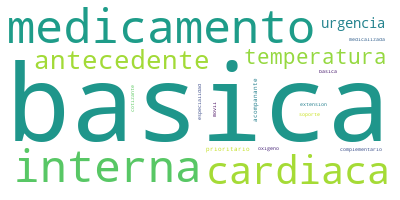

In [69]:
# Para la nube de palabras es necesario tener una cadena larga.
lista_mensajeuser=[]
for i in range(len(df_user)):
  lista_mensajeuser+=df_user['transcripcion'][i]#input debe ser un string
long_string=''.join(lista_mensajeuser)
# Creacion lista stop words
wordcloud = WordCloud(background_color="white",min_font_size=5, max_font_size=150, max_words=600, contour_width=50, contour_color='steelblue', margin=15, stopwords=lista_stop_words+['problema','pregunta'])
# Crear el word cloud
wordcloud.generate(long_string)
# Visualizar el word cloud
wordcloud.to_image()

In [70]:
segmento = str.upper("GENERAL")
# Iniciar el count vectorizer con stop words personalizado en español
count_vectorizer = CountVectorizer(stop_words=stopwords.words('spanish')+lista_stop_words)
# Ajustar y transformar los términos procesados
count_data = count_vectorizer.fit_transform(df_user['transcripcion'])
#Visualizar los términos mas comunes
plot_10_most_common_words(count_data, count_vectorizer)

(['temperatura',
  'cardiaca',
  'basica',
  'respiratoria',
  'medicamento',
  'arterial',
  'oxigeno',
  'interna',
  'urgencia',
  'prioritario',
  'soporte',
  'especialidad',
  'antecedentes',
  'cotizante',
  'complementario'],
 [280.0,
  272.0,
  227.0,
  175.0,
  167.0,
  161.0,
  147.0,
  134.0,
  134.0,
  113.0,
  109.0,
  107.0,
  101.0,
  100.0,
  96.0])

Guardado de la informacion limpia para el **usuario**, este paso es muy importante ya que define los dataframes con los que vamos a trabajar después.

#Afiliaciones

In [71]:
df_personal=df_user.copy()
#df_personal=df_personal.drop_duplicates('GUID') #Quitamos los duplicados porque algunas llamadas son transferidas a otros agentes que pertenecen a otras operaciones, y quedan con el mismo GUIID

In [72]:
df_personal.reset_index(inplace=True, drop=True)

In [73]:
#Eliminamos los espacios al inicio y al final de cada string
df_personal['transcripcion']=df_personal['transcripcion'].apply(lambda x: x.strip() if type(x)==str else x)

In [74]:
df_personal['transcripcion'][0:4]

0    presion comparsa confites guste darle incluyen...
1    tranvia documentos registrar tarjeta identidad...
2    contentos visto mosqueteros tantan traera vica...
3    consciente sables comprension referente recibe...
Name: transcripcion, dtype: object


<b><font color=orange size=5>Patrones</font></b>

**Necesitamos que el índice sea secuencial**




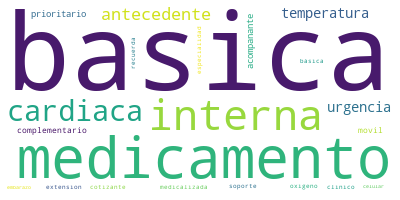

In [75]:
lista_mensajeuser=[]
for i in range(len(df_personal)):
  lista_mensajeuser+=df_personal['transcripcion'][i]
long_string=''.join(lista_mensajeuser)
#Creacion lista stop words
wordcloud = WordCloud(background_color="white",min_font_size=5, max_font_size=150, max_words=600, contour_width=50, contour_color='steelblue', margin=15, stopwords=lista_stop_words)
#Crear el word cloud
wordcloud.generate(long_string)
#Visualizar el word cloud
wordcloud.to_file('personal_patrones.png')
wordcloud.to_image()


<b><font color=orange size=5>TERMINOS CLAVE N-GRAMAS</font></b>

Para obtener la Figura de los N-Gramas solo debemos especificar el N-range en la función CountVectorizer para que este vectorice las palabras conjuntas.

A continuación se presenta la función para corregir la ortografía

In [76]:
lista=[(r'certificadoes','certificado'),(r'educativos','educativo'),(r'beneficiaria','beneficiario'),(r'solicita','solicitar'),(r'solicitud','solicita'),(r'beneficios','beneficio'),(r'legalizaron','legalizar'), (r'legalizacion','legalizar'),(r'personajes','personaje'), (r'certificadoes','certificado'), (r'certificacion','certificado'), (r'disponibles','disponible'),(r'certificados','certificado'), (r'documentos','documento'), (r'disfrute','disfrutar'), (r'pagara','pagar'), (r'pagare','pagar'),(r'tratando','tratar'),(r'reportes','reporte'),(r'desprendibles','desprendible')]
df_personal['transcripcion']=df_personal['transcripcion'].apply(lambda x: s_correction(x, lista))
print(lista[0:2])

[('certificadoes', 'certificado'), ('educativos', 'educativo')]


In [77]:
segmento = str.upper("USUARIO  EPS (N-gramas)")
# Iniciar el count vectorizer con stop words personalizado en español
count_vectorizer = CountVectorizer(stop_words=['entiendo','pregunta','desempena','quincena']+lista_stop_words,ngram_range=(3, 3))
# Ajustar y transformar los términos procesados
count_data = count_vectorizer.fit_transform(df_personal['transcripcion'])
#Visualizar los términos mas comunes
words,counts = plot_10_most_common_words(count_data, count_vectorizer)

In [78]:
n_gramas_for_powerbi = pd.DataFrame()
n_gramas_for_powerbi["word"] = words
n_gramas_for_powerbi["freq"] = counts
n_gramas_for_powerbi.set_index("word", inplace=True)


<b><font color=orange size=5> TERMINOS CLAVE</font></b>

In [79]:
segmento = str.upper("NUEVA EPS")
# Iniciar el count vectorizer con stop words personalizado en español
count_vectorizer = CountVectorizer(stop_words=['interes','ejemplo','personas','llega','hablar','nuevamente','envie','diciendo','llamada','envio','aparece','necesito','respuesta','informacion','entiendo','solicitud','problema','pregunta', 'haciendo']+lista_stop_words)
# Ajustar y transformar los términos procesados
count_data = count_vectorizer.fit_transform(df_personal['transcripcion'])
#Visualizar los términos mas comunes
plot_10_most_common_words(count_data, count_vectorizer)

(['temperatura',
  'cardiaca',
  'basica',
  'respiratoria',
  'medicamento',
  'arterial',
  'oxigeno',
  'interna',
  'urgencia',
  'prioritario',
  'soporte',
  'especialidad',
  'antecedentes',
  'cotizante',
  'complementario'],
 [280.0,
  272.0,
  227.0,
  175.0,
  167.0,
  161.0,
  147.0,
  134.0,
  134.0,
  113.0,
  109.0,
  107.0,
  101.0,
  100.0,
  96.0])

<b><font color=orange size=5> Modelado de topicos</font></b>

**EL INPUT DE ESTE MODELO ES UNA LISTA DE LISTAS NO SUPERVISADO, POR LO TANTO BUSCAR CLUSTERS EN EL TEXTO PATRONES, SEGUN METRICAS DE SEMEJAZA EN ESTE ES LA COHERENCIA.....LA SIMILARIDAD ENTRE PALABRAS Y ENTRE TOPICOS**

In [80]:
dw = list(sent_to_words(df_personal[['transcripcion']]['transcripcion']))

In [81]:
#@title Creación del Corpus
%%time

nlp = spacy.load('es_core_news_md')

#Oraciones a lista de palabras, remocion de puntuacion y caracteres innecesarios
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True remueve puctuacion

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in swseg] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#CREACION DEL CORPUS Y FACTORIZACION DE TERMINOS
#Analizando los mensajes del usuario en general
data=df_personal['transcripcion'].tolist()

data_words = list(sent_to_words(data))# Se crea una lista de listas

#BRIGRAMAS
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # Umbral superior de pocas frases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(dw, min_count=5, threshold=100))
trigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram[dw], threshold=100))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in lista_stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#Definicion de segmento a analizar
dw = list(sent_to_words(df_personal[['transcripcion']]['transcripcion']))
data_words_bigrams = make_bigrams(remove_stopwords(dw))
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 2min 55s, sys: 645 ms, total: 2min 56s
Wall time: 2min 56s


In [82]:
#@title Modelo LDA Optimizado 
%%time
#Visualización del modelo

pyLDAvis.enable_notebook()

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.909999999999999,
                                           eta=0.61,                                        
                                           per_word_topics=True)

#Visualizacion de los tópicos generados en el modelo LDA
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#Prerrequisitos minimos para la representacion grafica del modelado de topicos
d = id2word
c = corpus
lda = lda_model

#Parametros de visualizacion
data = pyLDAvis.gensim.prepare(lda, c, d)

#Persistencia de resultados de modelado de tópicos
pyLDAvis.save_html(data, 'vis_' + segmento + '.html')
print('\n\n')
#Visualizacion
display(data)


[(0,
  '0.005*"oficina" + 0.004*"permanencia" + 0.003*"afiliar" + 0.002*"pendiente" '
  '+ 0.002*"fecho" + 0.002*"quedo" + 0.002*"vetar" + 0.002*"autorización" + '
  '0.002*"actriz" + 0.002*"molestar"'),
 (1,
  '0.008*"procedimiento" + 0.007*"estancia" + 0.005*"autorizar" + '
  '0.004*"querer" + 0.003*"hacer" + 0.003*"informar" + 0.003*"pesar" + '
  '0.003*"generar" + 0.003*"procesar" + 0.003*"venir"'),
 (2,
  '0.013*"cardiaco" + 0.011*"temperatura" + 0.011*"basica" + '
  '0.010*"respiratorio" + 0.007*"prioritario" + 0.007*"medicamento" + '
  '0.006*"interno" + 0.006*"contar" + 0.006*"tomar" + 0.005*"hacer"')]





PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.122555  0.011926       1        1  74.817532
1      0.042167 -0.063326       2        1  17.922497
0      0.080388  0.051400       3        1   7.259971, topic_info=               Term        Freq       Total Category  logprob  loglift
515   procedimiento   42.000000   42.000000  Default  30.0000  30.0000
243        cardiaco  260.000000  260.000000  Default  29.0000  29.0000
315        estancia   43.000000   43.000000  Default  28.0000  28.0000
121     temperatura  234.000000  234.000000  Default  27.0000  27.0000
301          basica  219.000000  219.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1233        detener    2.445901    6.949262   Topic3  -6.7040   1.5786
31          existir    2.664787   25.484086   Topic3  -6.6183   0.3649
2758        directo    2.388144   10.055486   Topic3  -6.7279   1.1852
217       preguntar    2.645097   70.668050   Topic3  -6.6257  -0.6625
44         personar    2.466761   17.949859   Topic3  -6.6956   0.6381

[209 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2747      1  0.189412            6
2747      2  0.757647            6
60        1  0.984277  acompanante
668       1  0.161325       actriz
668       2  0.322649       actriz
...     ...       ...          ...
1740      3  0.754663      volumen
1316      1  0.136292          voz
1316      2  0.817750          voz
5685      1  0.432131        zenit
5685      3  0.432131        zenit

[362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

CPU times: user 2.99 s, sys: 1.12 s, total: 4.11 s
Wall time: 5.3 s


In [83]:
#@title Dominancia de Temas
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5098,"procedimiento, estancia, autorizar, querer, ha...","[gustar, darle, incluir, canción, tratar, crim..."
1,1,2.0,0.9451,"cardiaco, temperatura, basica, respiratorio, p...","[registrar, aparecer, aguar, necesitar, incide..."
2,2,2.0,0.5814,"cardiaco, temperatura, basica, respiratorio, p...","[contento, vestir, vicario, intencion, especie..."
3,3,2.0,0.8047,"cardiaco, temperatura, basica, respiratorio, p...","[consciente, sable, comprension, referente, re..."
4,4,1.0,0.7255,"procedimiento, estancia, autorizar, querer, ha...","[ignorar, herir, frazada, segundo, establecers..."
5,5,2.0,0.6426,"cardiaco, temperatura, basica, respiratorio, p...","[especie, oscuro, poder, complementario, elfo,..."
6,6,2.0,0.6631,"cardiaco, temperatura, basica, respiratorio, p...","[concienciar, venir, mellizo, producto, person..."
7,7,2.0,0.9555,"cardiaco, temperatura, basica, respiratorio, p...","[aparecer, allanar, certamen, sucio, contribut..."
8,8,2.0,0.7169,"cardiaco, temperatura, basica, respiratorio, p...","[piso, inseguro, conejito, integrar, restituci..."
9,9,2.0,0.9691,"cardiaco, temperatura, basica, respiratorio, p...","[perder, senal, duracion, embarazar, confirmar..."


In [84]:
#@title Oracion mas Representativa por cada Tema
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
    
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9066,"oficina, permanencia, afiliar, pendiente, fecho, quedo, vetar, autorización, actriz, molestar","[bienvenido, celebrar, genial, afiliar, quedo, lejos, oficina, salir, generar, autorización, dig..."
1,1.0,0.9739,"procedimiento, estancia, autorizar, querer, hacer, informar, pesar, generar, procesar, venir","[volver, central, elegir, escribir, afiliar, literalmente, prioritario, trivial, solidar, enviar..."
2,2.0,0.9827,"cardiaco, temperatura, basica, respiratorio, prioritario, medicamento, interno, contar, tomar, h...","[zona, prision, furioso, fraude, prioritario, indicar, interes, cazar, amable, cotizante, total,..."


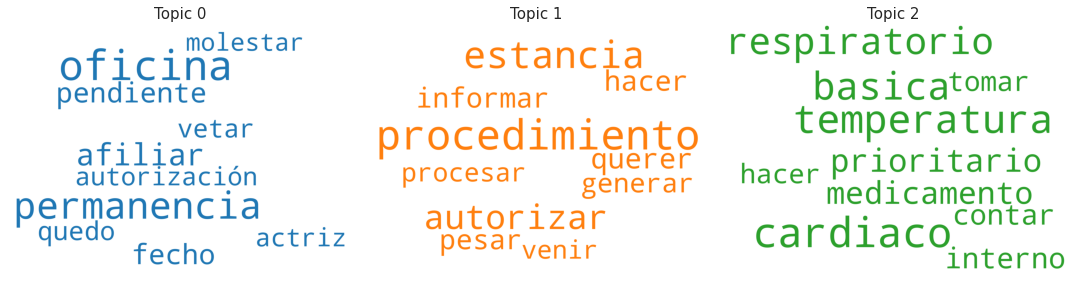

In [85]:
#@title Nubes de Palabras de los Términos clave N Principales en cada Tema
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=lista_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=15))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.savefig("personal_topics_results.png",bbox_inches = 'tight')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<b><font color=orange size=5> REDES SEMANTICAS</font></b>

Tener en cuenta que hay quitar palabras, la remoción de las palabras debe realizarce con mucho cuidado.

In [86]:
lista=[(r'ayudarlo','ayudar'),(r'certificadoes','certificado'),(r'educativos','educativo'),(r'beneficiaria','beneficiario'),(r'solicita','solicitar'),(r'solicitud','solicitar'),(r'beneficios','beneficio'),(r'legalizaron','legalizar'), (r'legalizacion','legalizar'),(r'personajes','personaje'), (r'certificadoes','certificado'), (r'certificacion','certificado'), (r'disponibles','disponible'),(r'certificados','certificado'), (r'documentos','documento'), (r'disfrute','disfrutar'), (r'pagara','pagar'), (r'pagare','pagar'),(r'tratando','tratar'),(r'reportes','reporte'),(r'desprendibles','desprendible')]
print(lista[0:2])
df_personal['transcripcion']=df_personal['transcripcion'].apply(lambda x: s_correction(x, lista))
print(df_personal['transcripcion'][0:2])

[('ayudarlo', 'ayudar'), ('certificadoes', 'certificado')]
0    presion comparsa confites guste darle incluyen canciones tratan crimen crueles mulas interinstit...
1    tranvia documento registrar tarjeta identidad aparece agua necesitaba incidente instalacion ficc...
Name: transcripcion, dtype: object


In [87]:
%%time
sw_w2v=['tibet','diciendome','certificadoes','certificadoes','solicitarr','solicitarndo','solicitardo','solicitarn','pesar','tranquilo','mandan','bendicion','bendecir','dios','caer','entraron','personalmente','acepta','tomado','meramente','sustituta','volvera','alta','ahorita','eseh','haciendo','haria','yendo','hayan','comedy','yoga','izzy','ayudo','medios','torneo','lados','deben','debia','debio','disculpame','climas','segundito','maldita','importe','menciono','quieras','pescar','entendido','caldo','entro','puto','puta','mierda','putos','putas','siguientes','listas','vuelvo','miren','hotel','poner','permite','contacto','conjunto','viene','abajo','existe','cliente','exactamente','quinientas','piden','amables','actual','perdona','llamaba','llevo','respecto','puesto','trato','hotmail','gustaria','escucho','celula','llamaba','vieja','podido','llamen','nuevamente','contestarrrrrrn','contestarrrrrrr','contestarrrrrr','contestarrrrdo','contestarrrrr','diciendo','actualmente','contestarrr', 'contestarrrdo','contestarrrn','contestarrrron', 'contestarrrr','dicho','volvio','sitio','hablado','cuentos','clientes','vieja','entran','venga','triple','aparecen','importa','pregunta','mirar','presente','color','estaciones','preguntar','llegado','contiene','cinta','lleva','contestarr','hagame','siguiente','cancion','maldicion','gmail','dije','pude','entrar','pistas','comento','quedan','quieres','ingrese','existen','esperan','cuerdo','simplemente','esperen','pese','altamente','indicar','cumplir','intentando','puntas','maneras','ambiente','tele','menciona','conozco','repente','hacerlo','tranquila','recuerde','acepto','normalmente','intentado','ninas','paren','ademas','pregunto','companero','consta','pidiendo','realizo','llame','visto','seguimiento','actuacion','llamando','cuestion','especies','cuestion','idea','disculpe','regalar','indica','inca','indica','siento','momentico','acerca','quisieron','quieren','hombres','debido','comuna','senores','hablo','this','acto','comunas','cuerda','adelante','mitad','vuelta','invierno','debia','parecio','mision','mananas','texto','maldito','aldeas','vieron','decirle','manejar','mantenido','exito','podian','quieren','conocen','parezca','hicieron','deberia','debemos','tratar','llamamos','caen','humor','llegue','actor','diseno','vienen','decia','anterior','talud','decide','curso','leyenda','dicto','ayudas','dejamos','aparecia','puedas','deje','hacerte','ayuden','darle','utah','rebelde','verlo','horno','podido','perdedor','necesitando','perfecto','perfectamente','callate','entiendo','detente','nuevamente','comentando','tanque','imaginate','momento','momentos','recorre','dependen','canciones','hicimos','atico','partir','claramente','pastizal','sirve','imbecil','bajas','montar','posterior','oyes','oye', 'llevan','parecen','necesitan','trae','aparece','posee','iguales','trajes','ahoritica','llevar','revisando','acido','culta','ultimos','vieja','podido','llamen','nuevamente','contestarrrrrrn','contestarrrrrrr','contestarrrrrr','contestarrrrdo','contestarrrrr','diciendo','actualmente','contestarrr', 'contestarrrdo','contestarrrn','contestarrrron', 'contestarrrr','dicho','volvio','sitio','hablado','leyenda','dicto','ayudas','dejamos','aparecia','puedas','deje','hacerte','ayuden','darle','especificado','utah','rebelde','verlo','horno','podido','perdedor','necesitando','perfecto','perfectamente','callate','entiendo','detente','nuevamente','comentando','tanque','imaginate','momento','momentos','recorre','dependen','canciones','hicimos','atico','partir','claramente','motivos','pastizal','detalles','sirve','imbecil','bajas','montar','posterior','oyes','oye', 'llevan','parecen','necesitan','trae','aparece','posee','iguales','trajes','ahoritica','llevar','revisando','acido','culta','ultimos']

df_personal['transcripcion1']=df_personal['transcripcion'].apply(lambda x: word_tokenize(x) )
df_personal['transcripcion1']=df_personal['transcripcion1'].apply(lambda x: [word for word in x if not word in sw_w2v] )
df_personal['transcripcion1']=df_personal['transcripcion1'].apply(lambda x: ' '.join(x) )
print(df_personal['transcripcion1'][0:2])

0    presion comparsa confites guste incluyen tratan crimen crueles mulas interinstitucional benefici...
1    tranvia documento registrar tarjeta identidad agua necesitaba incidente instalacion ficcion pers...
Name: transcripcion1, dtype: object
CPU times: user 437 ms, sys: 4.03 ms, total: 441 ms
Wall time: 440 ms


**todavía está sujeto a desarrollo**
un diccionario de hiperparametros, y correr el modelo para cada uno de ellos y evaluar los resultados

In [88]:
#@title Red Semántica

#CREACION DEL CORPUS Y FACTORIZACION DE TERMINOS
#Analizando los mensajes del usuario en general
data=df_personal['transcripcion1'].tolist()

#Oraciones a lista de palabras, remocion de puntuacion y caracteres innecesarios
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True remueve puctuacion

data_words = list(sent_to_words(data))# Se crea una lista de listas

#BRIGRAMAS
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # Umbral superior de pocas frases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])
# Funciones para bigrams, trigrams lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Aplicacion de las respectivas funciones
#Formacion de bigramas
data_words_bigrams = make_bigrams(data_words)

#Creacion del diccionario
id2word = corpora.Dictionary(data_words_bigrams)

# Creacion del Corpus
texts = data_words_bigrams

#Frecuencia termino documento
corpus = [id2word.doc2bow(text) for text in texts]

#VEMOS CUANTOS TERMINOS ESTAN EN NUESTRO DICCIONARIO Y CUALES SON LOS MÁS FRECUENTE
word_freq = defaultdict(int)
for sent in data_words_bigrams:
    for i in sent:
        word_freq[i] += 10
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[50:100]

cores = multiprocessing.cpu_count()

##Entrenamiento del Modelo
w2v_model = Word2Vec(min_count=7, #SE CONSTRUYE EL VOCABULARIO A PARTIR DE LA FRECUENCIA DE APARICION QUE SE DEFINA AQUI
                     window=3,#SE AJUSTA EL NUMERO DE PALABRAS ATRAS Y ADELANTE DE LA PALABRA OBJETIVO PARA VECORIZARLA
                     size=30, #EL TAMANO DEL VECTOR DE CADA PALABRA
                     sample=1e-4, #-5 en principio #ESTE ES EL PARAMETRO QUE HAY QUE AJUSTAR, ES EL MAS SENSIBLE DEL MODELO
                     alpha=0.003, 
                     min_alpha=0.007, 
                     negative=10,
                     workers=cores-1)

#Construccion de vocabulario
w2v_model.build_vocab(data_words_bigrams, progress_per=10000)

#Entrenamiento del modelo
a=w2v_model.train(data_words_bigrams, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)

#Terminos similares
# w2v_model.wv.most_similar(positive=["contrasena"], topn=10)

##FUNCION PARA REDUCIR LA DIMENSION DEL ESPACIO DE PALABRAS Y PODER VISUALIZARLAS
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 30), dtype='f')
    word_labels = [word]
    color_list  = ["#25427B"] #a los colores de la campaña

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append("#33BBFF")
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append("#EBECED")
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    freq=[]
    for i in word_labels:
       freq.append(word_freq[i])

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list,'freq':freq})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': df['freq'],
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ('+ df["words"][line].title()+','+str(df['freq'][line])+')',
                 horizontalalignment='left',
                 verticalalignment='top', size='small',
                 #color=df['color'][line],
                 color='black',
                 weight='normal'
                ).set_size(11)
    
    plt.axis(emit=True)
    plt.xlim(Y[:, 0].min()-10, Y[:, 0].max()+10)
    plt.ylim(Y[:, 1].min()-10, Y[:, 1].max()+30)
    plt.title('Visualización semántica para {}'.format(word.title()))

In [89]:
# %matplotlib inline
segmento = str.upper("Usuario Traslado Contributivo")
# Iniciar el count vectorizer con stop words personalizado en español
count_vectorizer = CountVectorizer(stop_words=['interes','ejemplo','personas','llega','hablar','nuevamente','envie',
                                               'diciendo','llamada','envio','aparece','necesito','respuesta','informacion',
                                               'entiendo','solicitud','problema','pregunta', 'haciendo']+lista_stop_words)
# Ajustar y transformar los términos procesados
count_data = count_vectorizer.fit_transform(df_personal['transcripcion'])
#Visualizar los términos mas comunes
x, y =plot_10_most_common_words(count_data, count_vectorizer)

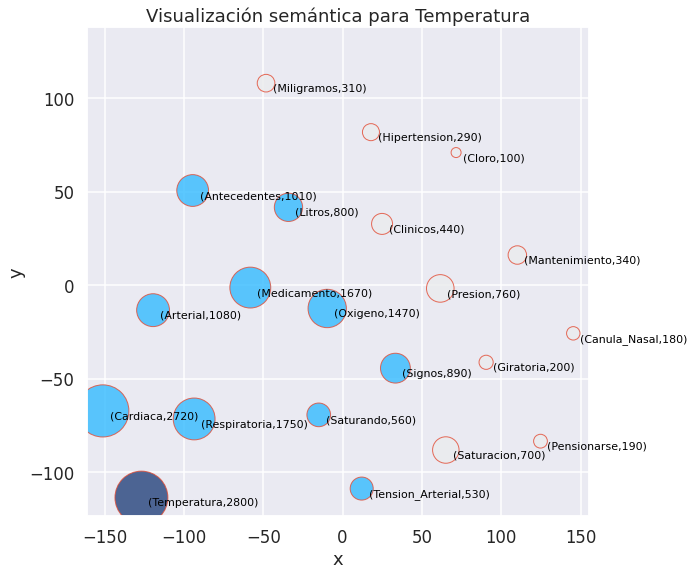

In [90]:
#@title
nombre = x[0]
tsnescatterplot(w2v_model, nombre, [t[0] for t in w2v_model.wv.most_similar(positive=[nombre], topn=20)][10:])
plt.savefig(nombre+"_calidad_personal_certificado.png",bbox_inches = 'tight')
##

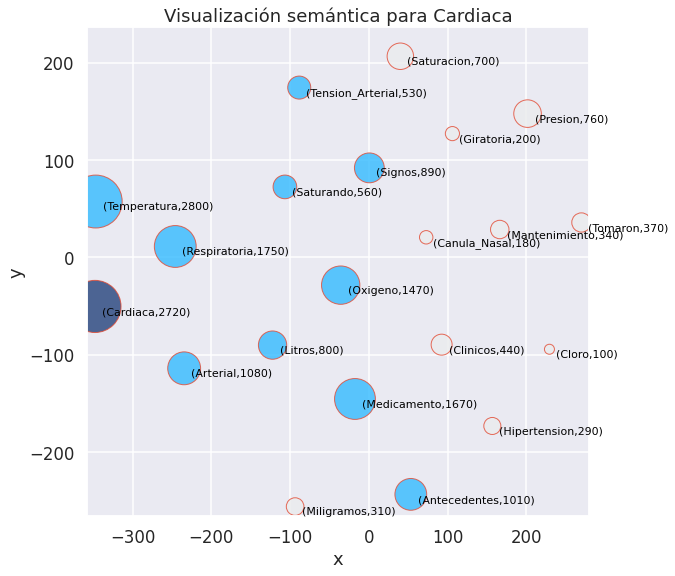

In [91]:
#@title
#carreras = ["Respiratorio", "Factura", "Enfermería"]


nombre = x[1]
tsnescatterplot(w2v_model, nombre, [t[0] for t in w2v_model.wv.most_similar(positive=[nombre], topn=20)][10:])
plt.savefig(nombre+"_calidad_personal_certificado.png",bbox_inches = 'tight')
##

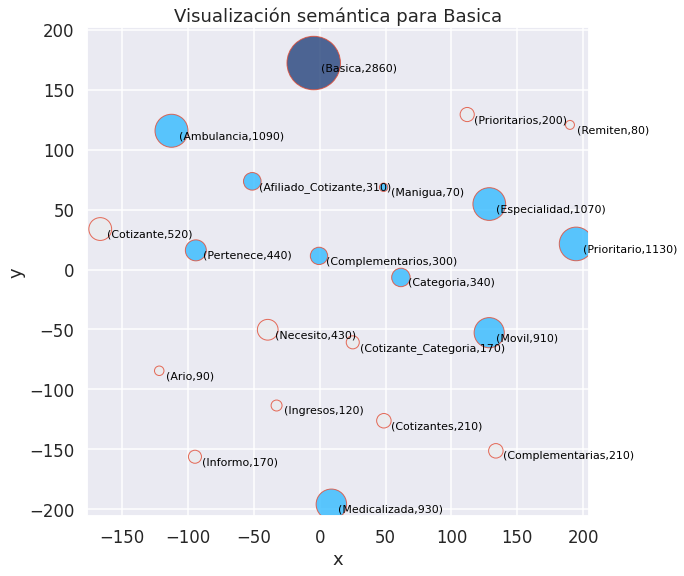

In [92]:
#@title
nombre = x[2]
tsnescatterplot(w2v_model, nombre, [t[0] for t in w2v_model.wv.most_similar(positive=[nombre], topn=20)][10:])
plt.savefig(nombre+"_calidad_personal_certificado.png",bbox_inches = 'tight')
##

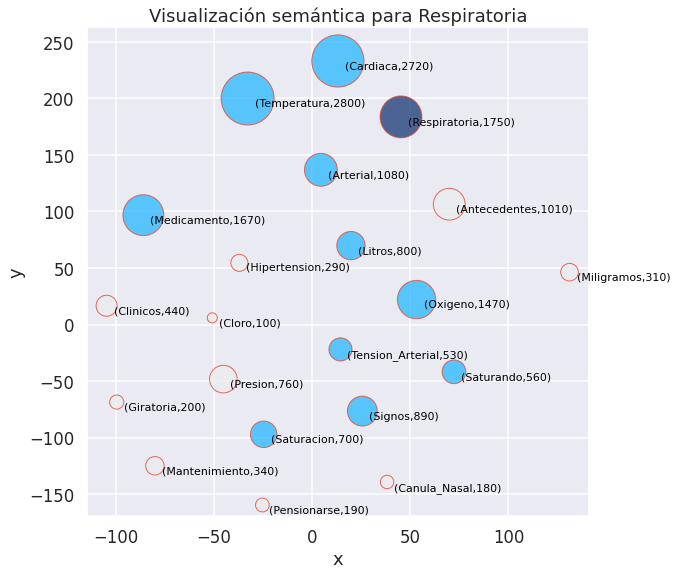

In [93]:
#@title
nombre = x[3]
tsnescatterplot(w2v_model, nombre, [t[0] for t in w2v_model.wv.most_similar(positive=[nombre], topn=20)][10:])
plt.savefig(nombre+"_calidad_personal_certificado.png",bbox_inches = 'tight')
##

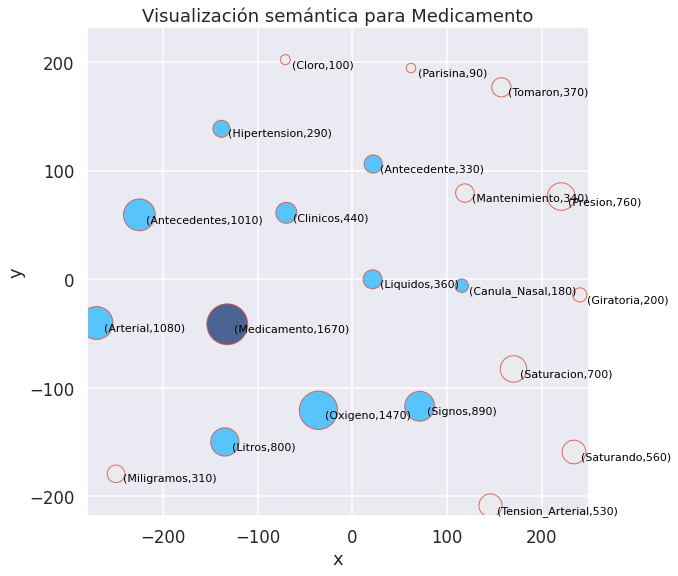

In [94]:
#@title
nombre = x[4]
tsnescatterplot(w2v_model, nombre, [t[0] for t in w2v_model.wv.most_similar(positive=[nombre], topn=20)][10:])
plt.savefig(nombre+"_calidad_personal_certificado.png",bbox_inches = 'tight')
##

Esta parte es muy relevante para poder realizar las gráficas en 3d. Al guardar el modelo de Word2Vec, da dos archivos uno contiene la vectorización de cada una de las palabras, y el otro contiene los labels de esa vectorización.

In [95]:
FOLDER_RAW

'/content/drive/MyDrive/NPL/'

In [96]:
 word_vectors = w2v_model.wv
 word_vectors.save_word2vec_format(FOLDER_RAW+'w2vecx')
 #Save model
from gensim.scripts.word2vec2tensor import word2vec2tensor 
word2vec2tensor(FOLDER_RAW+'w2vecx', FOLDER_RAW+'_tensor00')

<b><font color=orange size=5> DETECCION DE LA TIPOLOGIA DE LAS 

*   Elemento de lista
*   Elemento de lista

PALABRAS EMPLEADAS POR LOS AGENTES</font></b>

Para realiar esta parte, es necsariao previamente traducir el texto puro al inglés, es decir, el texto completo, con las stop-words y demás tal como lo obtenemos del algoritmo de speech to text.

In [97]:
segmento='general'

In [98]:
#!pip install googletrans==3.1.0a0

In [99]:
from googletrans import Translator
import pandas as pd
translator = Translator()

def en_translation(x):
  translate = translator.translate(x, src='es', dest='en')
  translate = translate.text
  return translate

In [100]:
en_translation("hola")

'Hello'

In [101]:
df_agent_afi[0:4]

,name_file,transcripcion,speech_ratio,confidance,owner,raw,Mes,agent,client,len_trans,media,desv,lim_atip_max,atipico
0,l0039661957_DATE-20200809104041_104748_NIT-X_CC-X_EXT-50723_AGE-18581.wav,no hay precio los días son la comparsa confinó confites les guste hablar nada de el tiene que d...,0.856,0.720000,usuario-Agente,"{\n ""result_index"": 0,\n ""results"": [\n {\n ""final"": true,\n ""alternatives"": [\n ...",Agosto,NaN,NaN,1082,2950.96468,1360.201296,7031.568567,False
1,l0039604092_DATE-20200803021036_021752_NIT-X_CC-X_EXT-52171_AGE-78334.wav,en qué zona tranvía casa con gente como ustedes buena manía en qué le puedo colaborar uno de la...,0.794,0.594000,usuario-Agente,"{\n ""result_index"": 0,\n ""results"": [\n {\n ""final"": true,\n ""alternatives"": [\n ...",Agosto,NaN,NaN,2127,2950.96468,1360.201296,7031.568567,False
2,l0039615405_DATE-20200804011623_012620_NIT-X_CC-X_EXT-52171_AGE-78334.wav,un par de días para contentos los semanas e buen día andrea cómo visto mosqueteros tantan rocke...,0.736,0.616111,usuario-Agente,"{\n ""result_index"": 0,\n ""results"": [\n {\n ""final"": true,\n ""alternatives"": [\n ...",Agosto,NaN,NaN,3534,2950.96468,1360.201296,7031.568567,False
3,l0039661974_DATE-20200809104404_105126_NIT-X_CC-X_EXT-50730_AGE-73712.wav,bienvenido a la línea en a éste se le hablan a quien ella consciente de sus sables sana la comp...,0.810,0.714444,usuario-Agente,"{\n ""result_index"": 0,\n ""results"": [\n {\n ""final"": true,\n ""alternatives"": [\n ...",Agosto,NaN,NaN,3338,2950.96468,1360.201296,7031.568567,False


In [102]:
#df_agent_afi = pd.read_parquet(FOLDER_RAW+"data/speech_icetex.parquet")
df_agent_afi = df_agent_afi [df_agent_afi.owner == "usuario-Agente"]
df_agent_afi = df_agent_afi [df_agent_afi["transcripcion"].notna()]

In [103]:
#print(df_agent_afi['owner'])

In [104]:
%%time
df_agent_afi["c_english"] = df_agent_afi["transcripcion"].apply(lambda x: en_translation(x))
df_agent_afi

CPU times: user 2.36 s, sys: 126 ms, total: 2.49 s
Wall time: 1min 19s


In [105]:
df = df_agent_afi.copy()

In [106]:
# Diccionario donde se guardarán los léxicos.
vocab={}
# Iteramos para cada una de las emociones de EmoLex.
for lexicon in os.listdir("EmoLex/"):
    # Se abre cada .txt, se extraen todas las palabras y se eliminan saltos de línea.
    with open("EmoLex/"+lexicon,"r") as f:
        vocab[lexicon.split(".")[0]]=[i[:-1] for i in f.readlines()]

In [107]:
def emotion_count(text,vocab):
    # Separamos las palábras por espacios.
    words=text.split(" ")
    # Creamos un diccionario donde se guardarán los conteos por cada emoción.
    counts={i:0 for i in list(vocab.keys())}
    # Creamos un diccionario donde se guardarán las palabras coincidentes con cada léxico.
    words_per_emo={i:[] for i in list(vocab.keys())}
    # Iteramos para cada una de las palábras dentro del texto.
    for word in words:
        # Iteramos para cada una de las emociones del léxico.
        for emo in vocab:
            # Evalúamos si la palabra está dentro del léxico de cada emoción
            if word in vocab[emo]:
                # Si la palabra está en el léxico de la emoción, sumamos 1 al conteo acumulado.
                counts[emo]+=1
                # También agregamos la palabra coincidente.
                words_per_emo[emo].append(word)
    return counts, words_per_emo

In [108]:
%%time
df['counts,detected_words']=df['c_english'].apply(lambda x: emotion_count(x,vocab)[0])

CPU times: user 28.4 s, sys: 4.4 ms, total: 28.4 s
Wall time: 28.4 s


In [109]:
dd = defaultdict(list)
list_emotions=df['counts,detected_words'].tolist()
for d in (list_emotions): 
     for key, value in d.items():
         dd[key].append(value)

for name, value in dd.items():
  dd[name]=sum(value)

In [110]:
dd0={}
for name, value in dd.items():
   if name=='anger':
    name='enojo'
    dd0[name]=value
  
   if name=='fear':
    name='ansiedad'
    dd0[name]=value
  
   if name=='trust':
    name='confianza'
    dd0[name]=value
  
   if name=='negative':
    name='negativa'
    dd0[name]=value
  
   if name=='anticipation':
    name='anticipación'
    dd0[name]=value
  
   if name=='disgust':
    name='disgusto'
    dd0[name]=value
  
   if name=='positive':
    name='positiva'
    dd0[name]=value
  
   if name=='joy':
    name='disfrute'
    dd0[name]=value
  
   if name=='surprise':
    name='sorpresa'
    dd0[name]=value
  
   if name=='sadness':
    name='aflicción'
    dd0[name]=value

In [111]:
df_p=pd.DataFrame(dd0, index=range(0,11))
df_p=df_p.T
df_p=df_p.rename(columns={0:'Frecuencia'})
df_p=df_p[['Frecuencia']]
df_p=df_p.sort_values(by='Frecuencia', ascending=False)

In [112]:
df_p

,Frecuencia
positiva,4636
confianza,2823
anticipación,2285
negativa,1704
ansiedad,1245
disfrute,1196
aflicción,953
sorpresa,763
enojo,577
disgusto,533


In [113]:
#plt.figure(figsize=(15,10))
fig=px.bar( x=df_p.index,color_discrete_sequence=["#25427B","#33BBFF","#EBECED"], y=df_p.Frecuencia, title='Ámbito de las expresiones utilizadas  en las conversaciones:',  labels=dict(x="Tipología de las palabras empleadas", y="Frecuencia", color="Place"))
fig.write_html("Experiencia emitida"+"_palabras_agente_.html")
fig.show()

In [114]:
df_personal_a=pd.DataFrame()
df_personal_a['cantidad_palabras']=list(dd0.values())
df_personal_a['tipo_palabra']=list(dd0.keys())

# <b><font color=orange size=5> DETECCION DE EMOCIONES </font></b>

Para la detección de emociones en el texto, debemos cargar el texto traducido al inglés. Se realia la aclaración de que el texto traducido debe ser el texto puro, con las stop-words y demás debido a que es necesario tener las frases completas para la clasificación.

Cargamos el modelo previamente entrenado para la obtención de las emociones

#Cargar el modelo


In [115]:
import keras 
import h5py

# model = keras.models.load_model(FOLDER_EMOTION_ANALISIS+'my_model_emotion.h5') 
model = keras.models.load_model('/content/drive/MyDrive/NUEVA EPS COD/Translado_contributivo/my_model_emotion_trasladoscon.h5')

Calculamos los sentimientos para cada conversación, el resultado es un diccionario con los porcentajes asignados de cada emoción para el texto en particular.

In [116]:
#df.iloc[0]['c_english']

In [117]:
dic_sentiment={}
for index, row in df.iterrows():
  new_dic={}
  result =get_sentiment(model,row['c_english'])
  result=result.set_index('sentiment')
  a=result.T.to_dict()
  for sentiment, value in a.items():
    new_dic[sentiment]=a[sentiment]['percentage']
  dic_sentiment[index]=new_dic

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

In [118]:
dic_sentiment

{0: {'anger': 3.0,
  'boredom': 1.0,
  'fear': 10.0,
  'hate': 1.0,
  'joy': 1.0,
  'sadness': 58.0,
  'surprise': 1.0,
  'worry': 23.0},
 1: {'anger': 15.0,
  'boredom': 1.0,
  'fear': 1.0,
  'fun': 1.0,
  'happiness': 1.0,
  'hate': 4.0,
  'joy': 5.0,
  'love': 3.0,
  'neutral': 1.0,
  'relief': 3.0,
  'sadness': 41.0,
  'surprise': 1.0,
  'worry': 25.0},
 2: {'anger': 1.0,
  'fun': 1.0,
  'happiness': 4.0,
  'hate': 1.0,
  'joy': 3.0,
  'love': 4.0,
  'neutral': 2.0,
  'relief': 3.0,
  'sadness': 40.0,
  'surprise': 2.0,
  'worry': 39.0},
 3: {'anger': 2.0,
  'fear': 11.0,
  'fun': 1.0,
  'happiness': 1.0,
  'joy': 3.0,
  'love': 7.0,
  'sadness': 5.0,
  'surprise': 70.0,
  'worry': 1.0},
 4: {'anger': 2.0, 'fear': 3.0, 'sadness': 94.0, 'worry': 1.0},
 5: {'anger': 7.0,
  'fear': 18.0,
  'fun': 1.0,
  'happiness': 1.0,
  'joy': 52.0,
  'love': 5.0,
  'neutral': 4.0,
  'sadness': 4.0,
  'surprise': 8.0,
  'worry': 2.0},
 6: {'anger': 1.0,
  'boredom': 1.0,
  'enthusiasm': 1.0,
  'hat

Realizamos la creación de una lista que va almacenando los resultados por sentimiento de cada una de las conversaciones, esto lo hacemos para hacer una ponderación después y obtener resultados globales de las emociones de los usuarios.

In [119]:
anger=[]
boredom=[]
empty=[]
fun=[]
happiness=[]
relief=[]
neutral=[]
worry=[]
love=[]
sadness=[]
surprise=[]
hate=[]
enthusiasm=[]
fear=[]
joy=[]
for name, value in dic_sentiment.items():
  for n, v in value.items():
    if n=='anger':
      anger.append(v)
    if n=='boredom':
      boredom.append(v)
    if n=='empty':
      empty.append(v)
    if n=='fun':
      fun.append(v)
    if n=='happiness':
      happiness.append(v)
    if n=='relief':
      relief.append(v)
    if n=='neutral':
      neutral.append(v)
    if n=='worry':
      worry.append(v)
    if n=='love':
      love.append(v)
    if n=='sadness':
      sadness.append(v)
    if n=='surprise':
      surprise.append(v)
    if n=='hate':
      hate.append(v)
    if n=='enthusiasm':
      enthusiasm.append(v)
    if n=='joy':
      joy.append(v)
    if n=='fear':
      fear.append(v)

In [120]:
sentiment=['enojo','desinterés','vacio','diversión','felicidad','alivio','neutral','preocupación','amor','incertidumbre','sorpresa','odio','entusiasmo', 'miedo', 'disfrute']
percentage=[sum(anger)/len(df),sum(boredom)/len(df),sum(empty)/len(df), sum(fun)/len(df), sum(happiness)/len(df), sum(relief)/len(df), sum(neutral)/len(df), sum(worry)/len(df), sum(love)/len(df),sum(sadness)/len(df), sum(surprise)/len(df), sum(hate)/len(df), sum(enthusiasm)/len(df), sum(fear)/len(df), sum(joy)/len(df)]
results=pd.DataFrame(sentiment)
results=results.rename(columns={0:'sentiment'})
results['percentage']=percentage

In [121]:
plot_result(results,'Distribución Emociones')

Para poder hacer la gráfica de sentimientos en versión polar debemos estandarizar todos los valores y esto lo hacemos con la función de MinMaxScaler()

In [122]:
#Para dibujar los sentimientos de forma polar
results=results.rename(columns={'sentiment':'sentimiento','percentage':'porcentaje'})
results=results.set_index('sentimiento')
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(results), columns=results.columns)
results.reset_index(inplace=True)
results=results['sentimiento']
df_scaled=df_scaled.merge(results, how='inner', on=results.index)

In [123]:
df_scaled_personal=df_scaled

In [124]:
fig=px.line_polar(df_scaled, 
              r="porcentaje", 
              theta="sentimiento", 
              title='Distribución de las emociones  en las conversaciones',
              #color="darkgreen", 
              line_close=True,
              line_shape='spline',
              range_r=[0, 1],
              color_discrete_sequence=["#25427B","gold"])
              #color_discrete_sequence=px.colors.qualitative.G10)
fig.write_html("personal_polar_usuario_.html")

In [125]:
fig.show()

<b><font color=orange size=5> Analisis de sentimientos</font></b>

In [126]:
df_personal0=df_personal

In [127]:
%%time
#Seleccion de los datos
segmento='Experiencia general del cliente'
df_personal=df_personal0
# df_personal=df_personal.rename(columns={'client':'transcripcion'})

# Normalizacion de valores perdidos
df_personal['transcripcion'] = df_personal['transcripcion'].apply(lambda x: '' if ((len(str(x)) == 3) & ((str(x) == 'NAN') | (str(x) == 'nan'))) | ((len(str(x)) == 4) & ((str(x) == 'NONE') | (str(x) == 'none') | (str(x) == 'None'))) else x)

# Aplicacion analisis de polaridad
#df_personal['polaridad_cliente'] = df_personal['transcripcion'].apply(lambda x: sentiment.sentiment(x))
df_personal['polaridad_cliente'] = df_personal['transcripcion'].apply(polaridad)

# Persistencia
# dfgral.to_parquet(rt1 + 'operativo_sentiment.parquet')

#Asignacion del sentimiento
df_personal['sentimiento_cliente'] = df_personal['polaridad_cliente'].apply(lambda x:'Negativos' if x<=0.001 else('Positivos' if x>=0.08 else 'Neutrales'))

df=df_personal
names = 'Negativos', 'Positivos', 'Neutrales'

b = len(df[df.sentimiento_cliente=='Positivos'])
a = len(df[df.sentimiento_cliente=='Negativos'])
c = len(df[df.sentimiento_cliente=='Neutrales'])

sizes=[a, b, c]

df0=pd.DataFrame()
df0['experiencia']=[ 'Negativos', 'Positivos', 'Neutrales']
df0['cantidad']=sizes

fig = px.pie(df0, values='cantidad', names='experiencia',hole=0.5,title=segmento,color_discrete_sequence=["#25427B","#33BBFF","#EBECED"])
fig.show()
fig.write_html(segmento+"_polaridad.html")

CPU times: user 38.5 s, sys: 207 ms, total: 38.7 s
Wall time: 38.9 s
